In [ ]:
eta = 0.1
optimizer_lr = 1e-5 # try 1e-5 from dim=2

dim = 12
n_center = 10
l = 5

num_layers = 30
width = 256

n_max_mirror_iterations= 10       # num mirror steps (for the frist and second)
n_max_iterations=6000        # max inner steps

num_samples = 10000         # number of theta generated for training
num_samples_test =  8192 # samples to estimate KL
import math
verbose = True
set_seed = 114540 # seed not used.
exp_number = 0 # [0, 1, 2, 3, 4]
pretrain_factor = 100

outer_lr_final_factor = 1e0
outer_eta_final_factor = 1e0
import math
outer_lr_factor = pow(math.e, math.log(outer_lr_final_factor)/n_max_mirror_iterations)
outer_eta_factor = pow(math.e, math.log(outer_eta_final_factor)/n_max_mirror_iterations)

In [ ]:
!pip install normflows

In [ ]:
import numpy as np
import zlib
from multipledispatch import dispatch
import torch
import random

class RandomManager:
    '''
    Manage random using crc32 checksum for seeds generating
    '''

    @staticmethod
    def _get_crc32_seed(_str):
        _bstr = str.encode(_str)
        return zlib.crc32(_bstr)

    def _make_str(self, *args):
        return '@'.join(map(str, args))

    def __init__(self, *args):
        self._str = self._make_str(*args)

    def get_seed(self, *postfixes):
        _str = self._str + self._make_str(*postfixes)
        return self._get_crc32_seed(_str)

    def seed_random(self, *postfixes):
        rnd_postfixes = ('random',) + postfixes
        random.seed(self.get_seed(*rnd_postfixes))
        return self

    def seed_torch(self, *postfixes):
        torch_postfixes = ('pytorch',) + postfixes
        torch.manual_seed(self.get_seed(*torch_postfixes))
        return self

    def seed_numpy(self, *postfixes):
        np_postfixes = ('numpy',) + postfixes
        np.random.seed(self.get_seed(*np_postfixes))
        return self

    def seed(self, *postfixes):
        return self.seed_random(*postfixes).seed_numpy(*postfixes).seed_torch(*postfixes)

def get_random_manager(*args):
    return RandomManager(*args)

In [ ]:
# Import required packages
import torch
import numpy as np
import normflows as nf
import os
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import torch.nn.functional as F
import torch.distributions as TD
import pandas as pd
import seaborn as sb
import torch.nn as nn
import shutil
import gc
import copy
import time
from scipy.optimize import linear_sum_assignment

In [ ]:
torch.manual_seed(114514)
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

In [ ]:
def random_centers_distrib_generator(n, n_rand, target_span, std, device='cpu', dtype=torch.float32):
    centers_sample_distrib = TD.Uniform(-target_span, target_span)
    centers = centers_sample_distrib.sample((n_rand, n)).to(device, dtype)
    comp = TD.Independent(TD.Normal(centers, torch.tensor([std,]).to(device, dtype)), 1)
    mix = TD.Categorical(torch.ones(n_rand,).to(device, dtype))
    target = TD.MixtureSameFamily(mix, comp)
    return target

def random_project(input_data, p = 2, random_seed = 114514):
  import torch
# input_data n by m
# random_matrix m by p
# random_projected = 1/sqrt(p) * input_data %*% random_matrix
  torch.manual_seed(random_seed)
  m = input_data.shape[1]
  random_mx = torch.randn((m, p))
  projected = (1/torch.sqrt(torch.tensor(p)))*torch.matmul(input_data, random_mx)
  return projected

def plot_two_data(target_dist, model_transform):
  import matplotlib.pyplot as plt
  import pandas as pd
  import seaborn as sb

  df_1 = pd.DataFrame(random_project(target_dist)).astype("float")
  df_2 =  pd.DataFrame(random_project(model_transform)).astype("float")

  df_1["type"] = "target dist"
  df_2["type"] = "model transform"
  df_all = pd.concat([df_1, df_2], ignore_index=True)
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)
  sns_plot = sb.jointplot(data=df_all, x="dim_0", y="dim_1", hue="type", kind="kde")
  return sns_plot

<ipython-input-20-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


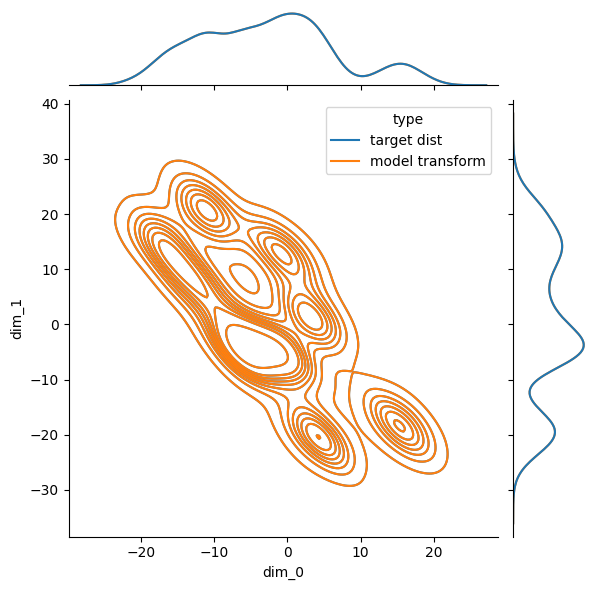

In [ ]:
r_m = get_random_manager('uran', dim, exp_number)
r_m.seed()

stationary_dist = random_centers_distrib_generator(n = dim, n_rand = n_center, target_span = l, std = 1, device=device, dtype=torch.float32)
target_samples = stationary_dist.sample((5000,))
plot_two_data(target_samples.cpu().detach(), target_samples.cpu().detach())

In [ ]:
kld1_hist = np.array([])
kld2_hist = np.array([])



trail_num = exp_number
torch.manual_seed(527)

# target_pretrain = TD.MultivariateNormal(
#     torch.zeros(dim).to(device), pretrain_factor * torch.eye(dim).to(device))
target_pretrain = TD.Uniform(-10, 10)
# Define 2D Gaussian base distribution
base = nf.distributions.DiagGaussian(dim, trainable=False)
# Define list of flows
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([int(dim/2), width, width, width, dim], init_zeros=True )
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(dim, mode='swap'))

# for i in range(num_layers):
#     flows += [nf.flows.AutoregressiveRationalQuadraticSpline(dim, 2, width)]
#     flows += [nf.flows.LULinearPermute(dim)]

# Construct flow model
model = nf.NormalizingFlow(base, flows).to(device)
optimizer1 = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

for it in tqdm(range(100)):
    optimizer1.zero_grad()

    # Get training samples
    # x = target_pretrain.sample((num_samples,)).to(device)
    x = target_pretrain.sample((num_samples, dim)).to(device)

    # Compute loss
    loss = model.forward_kld(x)

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer1.step()

    if it % 100 == 99:
      clear_output(wait=True)
      print('Loss:', loss.item())


100%|██████████| 100/100 [00:10<00:00,  9.21it/s]

Loss: 37.97715759277344


<ipython-input-20-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


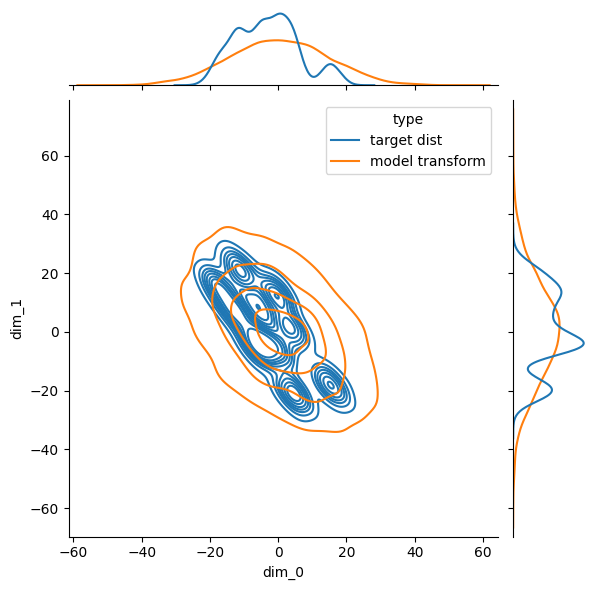

In [ ]:
target_samples = stationary_dist.sample((5000,))
model_samples, _ = model.sample(5000)
plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())

  2%|▏         | 100/6000 [00:32<34:50,  2.82it/s]

trail: 0 m step: 0 Loss: 86.9721794128418  L_n: 63.36355209350586  kld: 2.3608627319335938 KLD1: 62.71658706665039 KLD2: 12.155367851257324


  3%|▎         | 200/6000 [01:03<33:42,  2.87it/s]

trail: 0 m step: 0 Loss: 83.62336730957031  L_n: 57.80339813232422  kld: 2.5819969177246094 KLD1: 57.669036865234375 KLD2: 11.957420349121094


  5%|▌         | 300/6000 [01:35<33:26,  2.84it/s]

trail: 0 m step: 0 Loss: 82.01068115234375  L_n: 55.15391540527344  kld: 2.6856765747070312 KLD1: 55.3562126159668 KLD2: 11.703414916992188


  7%|▋         | 400/6000 [02:07<32:55,  2.83it/s]

trail: 0 m step: 0 Loss: 80.45015335083008  L_n: 53.084163665771484  kld: 2.7365989685058594 KLD1: 52.934906005859375 KLD2: 11.44015884399414


  8%|▊         | 500/6000 [02:39<32:12,  2.85it/s]

trail: 0 m step: 0 Loss: 79.87213897705078  L_n: 51.18351745605469  kld: 2.8688621520996094 KLD1: 51.03664016723633 KLD2: 11.283856391906738


 10%|█         | 600/6000 [03:11<31:42,  2.84it/s]

trail: 0 m step: 0 Loss: 79.54185104370117  L_n: 49.93381118774414  kld: 2.960803985595703 KLD1: 49.44548034667969 KLD2: 11.101279258728027


 12%|█▏        | 700/6000 [03:43<31:05,  2.84it/s]

trail: 0 m step: 0 Loss: 78.39348602294922  L_n: 48.509376525878906  kld: 2.9884109497070312 KLD1: 48.26858139038086 KLD2: 10.910135269165039


 13%|█▎        | 800/6000 [04:14<30:29,  2.84it/s]

trail: 0 m step: 0 Loss: 77.9725570678711  L_n: 47.35137176513672  kld: 3.0621185302734375 KLD1: 46.967369079589844 KLD2: 10.736466407775879


 15%|█▌        | 900/6000 [04:46<29:57,  2.84it/s]

trail: 0 m step: 0 Loss: 77.75431442260742  L_n: 46.438968658447266  kld: 3.1315345764160156 KLD1: 45.88174057006836 KLD2: 10.588682174682617


 17%|█▋        | 1000/6000 [05:18<29:22,  2.84it/s]

trail: 0 m step: 0 Loss: 76.28776931762695  L_n: 45.29964828491211  kld: 3.0988121032714844 KLD1: 45.61437225341797 KLD2: 10.440134048461914


 18%|█▊        | 1100/6000 [05:50<28:48,  2.84it/s]

trail: 0 m step: 0 Loss: 76.26879119873047  L_n: 44.92018127441406  kld: 3.1348609924316406 KLD1: 44.82738494873047 KLD2: 10.300230979919434


 20%|██        | 1200/6000 [06:22<28:12,  2.84it/s]

trail: 0 m step: 0 Loss: 75.58048248291016  L_n: 44.284515380859375  kld: 3.129596710205078 KLD1: 44.659202575683594 KLD2: 10.197416305541992


 22%|██▏       | 1300/6000 [06:54<27:38,  2.83it/s]

trail: 0 m step: 0 Loss: 75.52808380126953  L_n: 44.274383544921875  kld: 3.1253700256347656 KLD1: 44.340599060058594 KLD2: 10.094182968139648


 23%|██▎       | 1400/6000 [07:26<27:10,  2.82it/s]

trail: 0 m step: 0 Loss: 75.2099380493164  L_n: 43.88463592529297  kld: 3.1325302124023438 KLD1: 43.929691314697266 KLD2: 9.927120208740234


 25%|██▌       | 1500/6000 [07:58<26:34,  2.82it/s]

trail: 0 m step: 0 Loss: 74.42453384399414  L_n: 43.03617477416992  kld: 3.138835906982422 KLD1: 43.31017303466797 KLD2: 9.774321556091309


 27%|██▋       | 1600/6000 [08:30<25:51,  2.84it/s]

trail: 0 m step: 0 Loss: 74.47271347045898  L_n: 43.08889389038086  kld: 3.1383819580078125 KLD1: 42.967350006103516 KLD2: 9.72077751159668


 28%|██▊       | 1700/6000 [09:02<25:21,  2.83it/s]

trail: 0 m step: 0 Loss: 74.02867126464844  L_n: 42.608497619628906  kld: 3.142017364501953 KLD1: 42.500179290771484 KLD2: 9.653645515441895


 30%|███       | 1800/6000 [09:34<24:47,  2.82it/s]

trail: 0 m step: 0 Loss: 73.62275314331055  L_n: 42.071353912353516  kld: 3.155139923095703 KLD1: 42.07878112792969 KLD2: 9.568323135375977


 32%|███▏      | 1900/6000 [10:06<24:15,  2.82it/s]

trail: 0 m step: 0 Loss: 72.98360824584961  L_n: 41.255130767822266  kld: 3.1728477478027344 KLD1: 41.711891174316406 KLD2: 9.512078285217285


 33%|███▎      | 2000/6000 [10:38<23:32,  2.83it/s]

trail: 0 m step: 0 Loss: 72.94952774047852  L_n: 41.402896881103516  kld: 3.1546630859375 KLD1: 41.6289176940918 KLD2: 9.441644668579102


 35%|███▌      | 2100/6000 [11:10<22:58,  2.83it/s]

trail: 0 m step: 0 Loss: 72.39575576782227  L_n: 40.600215911865234  kld: 3.179553985595703 KLD1: 41.21504592895508 KLD2: 9.378777503967285


 37%|███▋      | 2200/6000 [11:42<22:26,  2.82it/s]

trail: 0 m step: 0 Loss: 72.65623092651367  L_n: 40.990962982177734  kld: 3.1665267944335938 KLD1: 41.21230697631836 KLD2: 9.369006156921387


 38%|███▊      | 2300/6000 [12:14<21:53,  2.82it/s]

trail: 0 m step: 0 Loss: 72.75066375732422  L_n: 40.704383850097656  kld: 3.2046279907226562 KLD1: 40.89500045776367 KLD2: 9.279440879821777


 40%|████      | 2400/6000 [12:46<21:17,  2.82it/s]

trail: 0 m step: 0 Loss: 72.4764518737793  L_n: 40.69807815551758  kld: 3.177837371826172 KLD1: 40.987022399902344 KLD2: 9.282215118408203


 42%|████▏     | 2500/6000 [13:18<20:36,  2.83it/s]

trail: 0 m step: 0 Loss: 72.36009979248047  L_n: 40.50909423828125  kld: 3.185100555419922 KLD1: 40.78749084472656 KLD2: 9.23263931274414


 43%|████▎     | 2600/6000 [13:50<20:01,  2.83it/s]

trail: 0 m step: 0 Loss: 72.77363967895508  L_n: 40.622379302978516  kld: 3.2151260375976562 KLD1: 40.456119537353516 KLD2: 9.194585800170898


 45%|████▌     | 2700/6000 [14:22<19:28,  2.82it/s]

trail: 0 m step: 0 Loss: 72.36963653564453  L_n: 40.370086669921875  kld: 3.1999549865722656 KLD1: 40.44281005859375 KLD2: 9.190719604492188


 47%|████▋     | 2800/6000 [14:54<18:54,  2.82it/s]

trail: 0 m step: 0 Loss: 72.60000228881836  L_n: 40.19876480102539  kld: 3.240123748779297 KLD1: 40.075035095214844 KLD2: 9.169376373291016


 48%|████▊     | 2900/6000 [15:26<18:17,  2.83it/s]

trail: 0 m step: 0 Loss: 72.52239608764648  L_n: 40.400089263916016  kld: 3.212230682373047 KLD1: 40.07972717285156 KLD2: 9.144329071044922


 50%|█████     | 3000/6000 [15:58<17:39,  2.83it/s]

trail: 0 m step: 0 Loss: 72.5314826965332  L_n: 40.33414077758789  kld: 3.2197341918945312 KLD1: 40.10749435424805 KLD2: 9.08464241027832


 52%|█████▏    | 3100/6000 [16:30<17:07,  2.82it/s]

trail: 0 m step: 0 Loss: 71.8241958618164  L_n: 39.96258544921875  kld: 3.1861610412597656 KLD1: 40.24658966064453 KLD2: 9.038389205932617


 53%|█████▎    | 3200/6000 [17:02<16:34,  2.82it/s]

trail: 0 m step: 0 Loss: 72.65616226196289  L_n: 40.41403579711914  kld: 3.224212646484375 KLD1: 39.82695007324219 KLD2: 9.004262924194336


 55%|█████▌    | 3300/6000 [17:34<15:55,  2.83it/s]

trail: 0 m step: 0 Loss: 72.25933074951172  L_n: 40.143089294433594  kld: 3.2116241455078125 KLD1: 39.88257598876953 KLD2: 8.99643325805664


 57%|█████▋    | 3400/6000 [18:07<15:25,  2.81it/s]

trail: 0 m step: 0 Loss: 71.79752349853516  L_n: 39.70386505126953  kld: 3.2093658447265625 KLD1: 39.96604919433594 KLD2: 9.020645141601562


 58%|█████▊    | 3500/6000 [18:39<14:46,  2.82it/s]

trail: 0 m step: 0 Loss: 72.04624938964844  L_n: 39.881141662597656  kld: 3.216510772705078 KLD1: 39.661800384521484 KLD2: 8.990797996520996


 60%|██████    | 3600/6000 [19:11<14:09,  2.83it/s]

trail: 0 m step: 0 Loss: 71.75030899047852  L_n: 39.350521087646484  kld: 3.239978790283203 KLD1: 39.5560188293457 KLD2: 9.000117301940918


 62%|██████▏   | 3700/6000 [19:43<13:32,  2.83it/s]

trail: 0 m step: 0 Loss: 71.81714248657227  L_n: 39.74152755737305  kld: 3.207561492919922 KLD1: 39.63372039794922 KLD2: 8.952320098876953


 63%|██████▎   | 3800/6000 [20:15<12:58,  2.83it/s]

trail: 0 m step: 0 Loss: 71.76145935058594  L_n: 39.81916809082031  kld: 3.1942291259765625 KLD1: 39.83295822143555 KLD2: 8.89758586883545


 65%|██████▌   | 3900/6000 [20:47<12:27,  2.81it/s]

trail: 0 m step: 0 Loss: 71.82185745239258  L_n: 39.403682708740234  kld: 3.2418174743652344 KLD1: 39.47312545776367 KLD2: 8.87704086303711


 67%|██████▋   | 4000/6000 [21:19<11:48,  2.82it/s]

trail: 0 m step: 0 Loss: 71.83954238891602  L_n: 39.28102493286133  kld: 3.2558517456054688 KLD1: 39.091487884521484 KLD2: 8.901946067810059


 68%|██████▊   | 4100/6000 [21:51<11:12,  2.82it/s]

trail: 0 m step: 0 Loss: 71.80419158935547  L_n: 39.38689422607422  kld: 3.241729736328125 KLD1: 39.23963165283203 KLD2: 8.881138801574707


 70%|███████   | 4200/6000 [22:23<10:36,  2.83it/s]

trail: 0 m step: 0 Loss: 71.45773696899414  L_n: 39.16300582885742  kld: 3.229473114013672 KLD1: 39.32210159301758 KLD2: 8.860861778259277


 72%|███████▏  | 4300/6000 [22:55<09:59,  2.84it/s]

trail: 0 m step: 0 Loss: 72.02943801879883  L_n: 39.688472747802734  kld: 3.2340965270996094 KLD1: 39.42164993286133 KLD2: 8.88542366027832


 73%|███████▎  | 4400/6000 [23:27<09:28,  2.82it/s]

trail: 0 m step: 0 Loss: 71.65859603881836  L_n: 39.28928756713867  kld: 3.2369308471679688 KLD1: 39.32826614379883 KLD2: 8.848052024841309


 75%|███████▌  | 4500/6000 [23:59<08:52,  2.82it/s]

trail: 0 m step: 0 Loss: 71.68990707397461  L_n: 39.3683967590332  kld: 3.2321510314941406 KLD1: 39.196109771728516 KLD2: 8.82970905303955


 77%|███████▋  | 4600/6000 [24:31<08:17,  2.82it/s]

trail: 0 m step: 0 Loss: 71.50339889526367  L_n: 39.151371002197266  kld: 3.2352027893066406 KLD1: 39.19886779785156 KLD2: 8.86385440826416


 78%|███████▊  | 4700/6000 [25:03<07:40,  2.82it/s]

trail: 0 m step: 0 Loss: 71.02904891967773  L_n: 39.10903549194336  kld: 3.1920013427734375 KLD1: 39.62535858154297 KLD2: 8.831106185913086


 80%|████████  | 4800/6000 [25:35<07:05,  2.82it/s]

trail: 0 m step: 0 Loss: 71.5271987915039  L_n: 39.407066345214844  kld: 3.2120132446289062 KLD1: 39.438987731933594 KLD2: 8.820758819580078


 82%|████████▏ | 4900/6000 [26:07<06:29,  2.82it/s]

trail: 0 m step: 0 Loss: 71.35657501220703  L_n: 39.266082763671875  kld: 3.2090492248535156 KLD1: 39.48722457885742 KLD2: 8.801868438720703


 83%|████████▎ | 5000/6000 [26:39<05:55,  2.82it/s]

trail: 0 m step: 0 Loss: 71.80410766601562  L_n: 39.40973663330078  kld: 3.2394371032714844 KLD1: 39.041080474853516 KLD2: 8.824068069458008


 85%|████████▌ | 5100/6000 [27:12<05:19,  2.81it/s]

trail: 0 m step: 0 Loss: 71.20824813842773  L_n: 39.1142463684082  kld: 3.209400177001953 KLD1: 39.30697250366211 KLD2: 8.82275104522705


 87%|████████▋ | 5200/6000 [27:44<04:43,  2.82it/s]

trail: 0 m step: 0 Loss: 71.6208610534668  L_n: 39.262386322021484  kld: 3.2358474731445312 KLD1: 39.07163619995117 KLD2: 8.802356719970703


 88%|████████▊ | 5300/6000 [28:16<04:08,  2.82it/s]

trail: 0 m step: 0 Loss: 71.57102966308594  L_n: 39.25627136230469  kld: 3.231475830078125 KLD1: 39.167884826660156 KLD2: 8.774018287658691


 90%|█████████ | 5400/6000 [28:48<03:32,  2.82it/s]

trail: 0 m step: 0 Loss: 71.03937911987305  L_n: 38.7652473449707  kld: 3.2274131774902344 KLD1: 39.04774856567383 KLD2: 8.749199867248535


 92%|█████████▏| 5500/6000 [29:20<02:57,  2.82it/s]

trail: 0 m step: 0 Loss: 71.57895278930664  L_n: 39.08982467651367  kld: 3.248912811279297 KLD1: 38.9611930847168 KLD2: 8.754488945007324


 93%|█████████▎| 5600/6000 [29:52<02:21,  2.82it/s]

trail: 0 m step: 0 Loss: 71.81999588012695  L_n: 39.321407318115234  kld: 3.249858856201172 KLD1: 38.77336883544922 KLD2: 8.753604888916016


 95%|█████████▌| 5700/6000 [30:24<01:46,  2.82it/s]

trail: 0 m step: 0 Loss: 71.45661544799805  L_n: 39.04935073852539  kld: 3.2407264709472656 KLD1: 38.92046356201172 KLD2: 8.770227432250977


 97%|█████████▋| 5800/6000 [30:56<01:10,  2.83it/s]

trail: 0 m step: 0 Loss: 71.3106460571289  L_n: 38.905364990234375  kld: 3.240528106689453 KLD1: 38.97480010986328 KLD2: 8.72183609008789


 98%|█████████▊| 5900/6000 [31:28<00:35,  2.83it/s]

trail: 0 m step: 0 Loss: 71.24648666381836  L_n: 38.806453704833984  kld: 3.2440032958984375 KLD1: 38.99159240722656 KLD2: 8.750277519226074


100%|██████████| 6000/6000 [32:00<00:00,  3.12it/s]

trail: 0 m step: 0 Loss: 71.06458282470703  L_n: 38.590370178222656  kld: 3.2474212646484375 KLD1: 38.75929641723633 KLD2: 8.75089168548584



<ipython-input-20-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


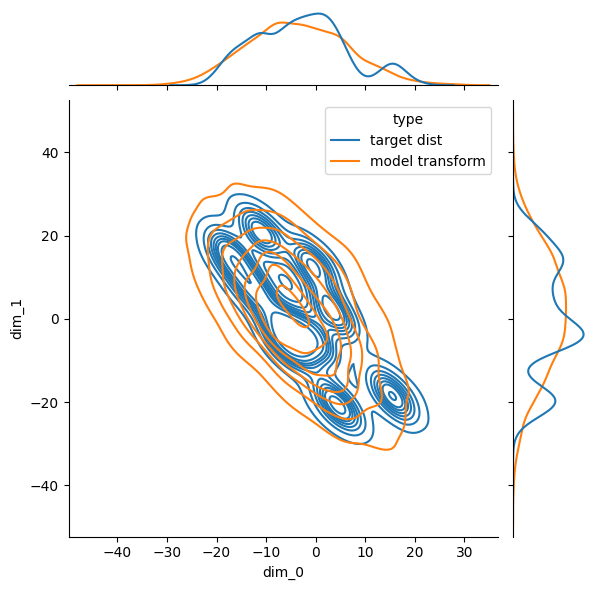

trail: 0 m step: 0 kl_test: 39.288963317871094


  2%|▏         | 100/6000 [00:32<35:13,  2.79it/s]

trail: 0 m step: 1 Loss: 29.59644317626953  L_n: 23.723831176757812  kld: 0.5872611999511719 KLD1: 23.461612701416016 KLD2: 6.786487102508545


  3%|▎         | 200/6000 [01:04<34:12,  2.83it/s]

trail: 0 m step: 1 Loss: 28.85873794555664  L_n: 22.56072998046875  kld: 0.6298007965087891 KLD1: 22.515661239624023 KLD2: 6.650715351104736


  5%|▌         | 300/6000 [01:36<33:58,  2.80it/s]

trail: 0 m step: 1 Loss: 28.62178611755371  L_n: 22.21257972717285  kld: 0.6409206390380859 KLD1: 22.15044403076172 KLD2: 6.495277404785156


  7%|▋         | 400/6000 [02:08<33:01,  2.83it/s]

trail: 0 m step: 1 Loss: 28.228931427001953  L_n: 21.81386947631836  kld: 0.6415061950683594 KLD1: 21.92251205444336 KLD2: 6.355594158172607


  8%|▊         | 500/6000 [02:41<32:31,  2.82it/s]

trail: 0 m step: 1 Loss: 28.255939483642578  L_n: 21.495018005371094  kld: 0.6760921478271484 KLD1: 21.61077308654785 KLD2: 6.345943927764893


 10%|█         | 600/6000 [03:13<32:06,  2.80it/s]

trail: 0 m step: 1 Loss: 28.488662719726562  L_n: 21.5760498046875  kld: 0.6912612915039062 KLD1: 21.34507942199707 KLD2: 6.298761367797852


 12%|█▏        | 700/6000 [03:45<31:30,  2.80it/s]

trail: 0 m step: 1 Loss: 28.29155921936035  L_n: 21.295995712280273  kld: 0.6995563507080078 KLD1: 21.09292221069336 KLD2: 6.198095798492432


 13%|█▎        | 800/6000 [04:17<30:48,  2.81it/s]

trail: 0 m step: 1 Loss: 28.178699493408203  L_n: 21.04912567138672  kld: 0.7129573822021484 KLD1: 20.986553192138672 KLD2: 6.186893939971924


 15%|█▌        | 900/6000 [04:49<30:08,  2.82it/s]

trail: 0 m step: 1 Loss: 27.958890914916992  L_n: 20.829317092895508  kld: 0.7129573822021484 KLD1: 20.82818603515625 KLD2: 6.1735334396362305


 17%|█▋        | 1000/6000 [05:22<29:43,  2.80it/s]

trail: 0 m step: 1 Loss: 27.517032623291016  L_n: 20.5841064453125  kld: 0.6932926177978516 KLD1: 20.90264320373535 KLD2: 6.1187543869018555


 18%|█▊        | 1100/6000 [05:54<29:15,  2.79it/s]

trail: 0 m step: 1 Loss: 27.78326988220215  L_n: 20.5959415435791  kld: 0.7187328338623047 KLD1: 20.496105194091797 KLD2: 6.089621067047119


 20%|██        | 1200/6000 [06:26<28:34,  2.80it/s]

trail: 0 m step: 1 Loss: 27.39687728881836  L_n: 20.250003814697266  kld: 0.7146873474121094 KLD1: 20.607511520385742 KLD2: 6.07296085357666


 22%|██▏       | 1300/6000 [06:58<27:50,  2.81it/s]

trail: 0 m step: 1 Loss: 27.55433464050293  L_n: 20.458463668823242  kld: 0.7095870971679688 KLD1: 20.630884170532227 KLD2: 6.071247100830078


 23%|██▎       | 1400/6000 [07:30<27:13,  2.82it/s]

trail: 0 m step: 1 Loss: 27.689367294311523  L_n: 20.40049171447754  kld: 0.7288875579833984 KLD1: 20.251171112060547 KLD2: 5.976675033569336


 25%|██▌       | 1500/6000 [08:03<26:44,  2.81it/s]

trail: 0 m step: 1 Loss: 27.53047752380371  L_n: 20.239370346069336  kld: 0.7291107177734375 KLD1: 20.250099182128906 KLD2: 5.925353527069092


 27%|██▋       | 1600/6000 [08:35<26:00,  2.82it/s]

trail: 0 m step: 1 Loss: 27.594310760498047  L_n: 20.332252502441406  kld: 0.7262058258056641 KLD1: 20.260066986083984 KLD2: 5.9361348152160645


 28%|██▊       | 1700/6000 [09:07<25:32,  2.81it/s]

trail: 0 m step: 1 Loss: 27.706270217895508  L_n: 20.379419326782227  kld: 0.7326850891113281 KLD1: 20.035892486572266 KLD2: 5.957638740539551


 30%|███       | 1800/6000 [09:39<24:52,  2.81it/s]

trail: 0 m step: 1 Loss: 27.315561294555664  L_n: 19.87674903869629  kld: 0.7438812255859375 KLD1: 19.9490909576416 KLD2: 5.911632061004639


 32%|███▏      | 1900/6000 [10:11<24:19,  2.81it/s]

trail: 0 m step: 1 Loss: 27.32891845703125  L_n: 19.781482696533203  kld: 0.7547435760498047 KLD1: 19.809221267700195 KLD2: 5.921854496002197


 33%|███▎      | 2000/6000 [10:43<23:47,  2.80it/s]

trail: 0 m step: 1 Loss: 27.22813606262207  L_n: 20.005388259887695  kld: 0.7222747802734375 KLD1: 20.07500457763672 KLD2: 5.911130905151367


 35%|███▌      | 2100/6000 [11:16<23:08,  2.81it/s]

trail: 0 m step: 1 Loss: 27.019887924194336  L_n: 19.585119247436523  kld: 0.7434768676757812 KLD1: 19.897302627563477 KLD2: 5.88883638381958


 37%|███▋      | 2200/6000 [11:48<22:35,  2.80it/s]

trail: 0 m step: 1 Loss: 27.122419357299805  L_n: 19.77931785583496  kld: 0.7343101501464844 KLD1: 19.93416404724121 KLD2: 5.897510051727295


 38%|███▊      | 2300/6000 [12:20<22:02,  2.80it/s]

trail: 0 m step: 1 Loss: 27.19319725036621  L_n: 19.735387802124023  kld: 0.7457809448242188 KLD1: 19.777423858642578 KLD2: 5.849079608917236


 40%|████      | 2400/6000 [12:52<21:28,  2.79it/s]

trail: 0 m step: 1 Loss: 27.036081314086914  L_n: 19.5886287689209  kld: 0.7447452545166016 KLD1: 19.8572940826416 KLD2: 5.861730098724365


 42%|████▏     | 2500/6000 [13:25<20:44,  2.81it/s]

trail: 0 m step: 1 Loss: 27.095735549926758  L_n: 19.68654441833496  kld: 0.7409191131591797 KLD1: 19.828535079956055 KLD2: 5.855979919433594


 43%|████▎     | 2600/6000 [13:57<20:08,  2.81it/s]

trail: 0 m step: 1 Loss: 27.259748458862305  L_n: 19.65278434753418  kld: 0.7606964111328125 KLD1: 19.637895584106445 KLD2: 5.818737983703613


 45%|████▌     | 2700/6000 [14:29<19:36,  2.81it/s]

trail: 0 m step: 1 Loss: 27.198402404785156  L_n: 19.616901397705078  kld: 0.7581501007080078 KLD1: 19.571510314941406 KLD2: 5.837498664855957


 47%|████▋     | 2800/6000 [15:02<19:03,  2.80it/s]

trail: 0 m step: 1 Loss: 27.337583541870117  L_n: 19.67164421081543  kld: 0.7665939331054688 KLD1: 19.515151977539062 KLD2: 5.848757743835449


 48%|████▊     | 2900/6000 [15:34<18:28,  2.80it/s]

trail: 0 m step: 1 Loss: 27.276519775390625  L_n: 19.559825897216797  kld: 0.7716693878173828 KLD1: 19.412511825561523 KLD2: 5.833192825317383


 50%|█████     | 3000/6000 [16:06<17:46,  2.81it/s]

trail: 0 m step: 1 Loss: 27.319272994995117  L_n: 19.732126235961914  kld: 0.7587146759033203 KLD1: 19.53398323059082 KLD2: 5.800046920776367


 52%|█████▏    | 3100/6000 [16:38<17:12,  2.81it/s]

trail: 0 m step: 1 Loss: 26.85066795349121  L_n: 19.510637283325195  kld: 0.7340030670166016 KLD1: 19.816450119018555 KLD2: 5.7941741943359375


 53%|█████▎    | 3200/6000 [17:10<16:36,  2.81it/s]

trail: 0 m step: 1 Loss: 27.353778839111328  L_n: 19.733654022216797  kld: 0.7620124816894531 KLD1: 19.557641983032227 KLD2: 5.768708229064941


 55%|█████▌    | 3300/6000 [17:43<16:05,  2.80it/s]

trail: 0 m step: 1 Loss: 27.207616806030273  L_n: 19.625524520874023  kld: 0.758209228515625 KLD1: 19.46792221069336 KLD2: 5.7835187911987305


 57%|█████▋    | 3400/6000 [18:15<15:25,  2.81it/s]

trail: 0 m step: 1 Loss: 26.970136642456055  L_n: 19.416330337524414  kld: 0.7553806304931641 KLD1: 19.579429626464844 KLD2: 5.815011024475098


 58%|█████▊    | 3500/6000 [18:47<14:47,  2.82it/s]

trail: 0 m step: 1 Loss: 27.242794036865234  L_n: 19.620227813720703  kld: 0.7622566223144531 KLD1: 19.39395523071289 KLD2: 5.810151100158691


 60%|██████    | 3600/6000 [19:19<14:17,  2.80it/s]

trail: 0 m step: 1 Loss: 26.956008911132812  L_n: 19.29876708984375  kld: 0.7657241821289062 KLD1: 19.51416778564453 KLD2: 5.840170383453369


 62%|██████▏   | 3700/6000 [19:52<13:38,  2.81it/s]

trail: 0 m step: 1 Loss: 27.04184341430664  L_n: 19.35028839111328  kld: 0.7691555023193359 KLD1: 19.360551834106445 KLD2: 5.781169414520264


 63%|██████▎   | 3800/6000 [20:24<13:08,  2.79it/s]

trail: 0 m step: 1 Loss: 27.0843563079834  L_n: 19.5408878326416  kld: 0.7543468475341797 KLD1: 19.491615295410156 KLD2: 5.749162673950195


 65%|██████▌   | 3900/6000 [20:56<12:28,  2.80it/s]

trail: 0 m step: 1 Loss: 26.98068618774414  L_n: 19.247474670410156  kld: 0.7733211517333984 KLD1: 19.315528869628906 KLD2: 5.750568389892578


 67%|██████▋   | 4000/6000 [21:29<11:53,  2.80it/s]

trail: 0 m step: 1 Loss: 27.24924659729004  L_n: 19.379716873168945  kld: 0.7869529724121094 KLD1: 19.259183883666992 KLD2: 5.777947902679443


 68%|██████▊   | 4100/6000 [22:01<11:16,  2.81it/s]

trail: 0 m step: 1 Loss: 27.167299270629883  L_n: 19.309919357299805  kld: 0.7857379913330078 KLD1: 19.112499237060547 KLD2: 5.768840312957764


 70%|███████   | 4200/6000 [22:33<10:40,  2.81it/s]

trail: 0 m step: 1 Loss: 26.825986862182617  L_n: 19.136091232299805  kld: 0.7689895629882812 KLD1: 19.324134826660156 KLD2: 5.763558387756348


 72%|███████▏  | 4300/6000 [23:05<10:03,  2.82it/s]

trail: 0 m step: 1 Loss: 27.075363159179688  L_n: 19.45050811767578  kld: 0.7624855041503906 KLD1: 19.418516159057617 KLD2: 5.803106784820557


 73%|███████▎  | 4400/6000 [23:37<09:30,  2.80it/s]

trail: 0 m step: 1 Loss: 27.046829223632812  L_n: 19.244094848632812  kld: 0.7802734375 KLD1: 19.208200454711914 KLD2: 5.755662441253662


 75%|███████▌  | 4500/6000 [24:10<08:56,  2.80it/s]

trail: 0 m step: 1 Loss: 27.072288513183594  L_n: 19.32391357421875  kld: 0.7748374938964844 KLD1: 19.27167510986328 KLD2: 5.748976230621338


 77%|███████▋  | 4600/6000 [24:42<08:19,  2.80it/s]

trail: 0 m step: 1 Loss: 27.026016235351562  L_n: 19.274951934814453  kld: 0.7751064300537109 KLD1: 19.27269172668457 KLD2: 5.781805515289307


 78%|███████▊  | 4700/6000 [25:14<07:45,  2.79it/s]

trail: 0 m step: 1 Loss: 26.78478240966797  L_n: 19.225997924804688  kld: 0.7558784484863281 KLD1: 19.40913963317871 KLD2: 5.752287864685059


 80%|████████  | 4800/6000 [25:47<07:09,  2.79it/s]

trail: 0 m step: 1 Loss: 26.902273178100586  L_n: 19.291494369506836  kld: 0.761077880859375 KLD1: 19.36286163330078 KLD2: 5.749729633331299


 82%|████████▏ | 4900/6000 [26:19<06:29,  2.82it/s]

trail: 0 m step: 1 Loss: 26.94603157043457  L_n: 19.353830337524414  kld: 0.7592201232910156 KLD1: 19.370771408081055 KLD2: 5.743738651275635


 83%|████████▎ | 5000/6000 [26:51<05:57,  2.80it/s]

trail: 0 m step: 1 Loss: 27.1193790435791  L_n: 19.3125057220459  kld: 0.7806873321533203 KLD1: 19.09908676147461 KLD2: 5.754716396331787


 85%|████████▌ | 5100/6000 [27:23<05:21,  2.80it/s]

trail: 0 m step: 1 Loss: 26.702472686767578  L_n: 19.126846313476562  kld: 0.7575626373291016 KLD1: 19.351280212402344 KLD2: 5.774179458618164


 87%|████████▋ | 5200/6000 [27:56<04:44,  2.81it/s]

trail: 0 m step: 1 Loss: 27.059898376464844  L_n: 19.34539794921875  kld: 0.7714500427246094 KLD1: 19.262990951538086 KLD2: 5.763436317443848


 88%|████████▊ | 5300/6000 [28:28<04:09,  2.80it/s]

trail: 0 m step: 1 Loss: 26.978660583496094  L_n: 19.273162841796875  kld: 0.7705497741699219 KLD1: 19.249292373657227 KLD2: 5.732421875


 90%|█████████ | 5400/6000 [29:00<03:34,  2.79it/s]

trail: 0 m step: 1 Loss: 26.863374710083008  L_n: 19.162588119506836  kld: 0.7700786590576172 KLD1: 19.18412208557129 KLD2: 5.728622913360596


 92%|█████████▏| 5500/6000 [29:33<02:57,  2.82it/s]

trail: 0 m step: 1 Loss: 27.009723663330078  L_n: 19.130752563476562  kld: 0.7878971099853516 KLD1: 19.15117835998535 KLD2: 5.72786283493042


 93%|█████████▎| 5600/6000 [30:05<02:22,  2.80it/s]

trail: 0 m step: 1 Loss: 27.168109893798828  L_n: 19.28316879272461  kld: 0.7884941101074219 KLD1: 19.010000228881836 KLD2: 5.725531101226807


 95%|█████████▌| 5700/6000 [30:37<01:47,  2.79it/s]

trail: 0 m step: 1 Loss: 27.054241180419922  L_n: 19.3446044921875  kld: 0.7709636688232422 KLD1: 19.278701782226562 KLD2: 5.757873058319092


 97%|█████████▋| 5800/6000 [31:09<01:11,  2.81it/s]

trail: 0 m step: 1 Loss: 26.90821075439453  L_n: 19.185832977294922  kld: 0.7722377777099609 KLD1: 19.191390991210938 KLD2: 5.719837188720703


 98%|█████████▊| 5900/6000 [31:42<00:35,  2.80it/s]

trail: 0 m step: 1 Loss: 26.904375076293945  L_n: 19.14606285095215  kld: 0.7758312225341797 KLD1: 19.192073822021484 KLD2: 5.746232509613037


100%|██████████| 6000/6000 [32:14<00:00,  3.10it/s]

trail: 0 m step: 1 Loss: 26.79555320739746  L_n: 18.95427131652832  kld: 0.7841281890869141 KLD1: 19.030847549438477 KLD2: 5.751225471496582



<ipython-input-20-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


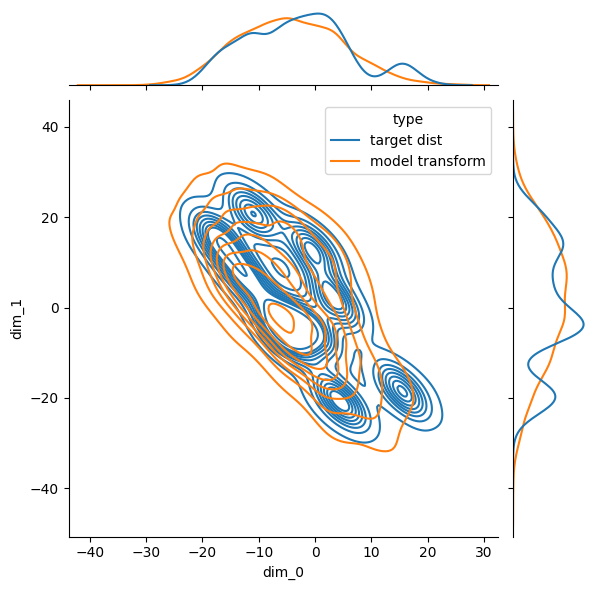

trail: 0 m step: 1 kl_test: 19.44001579284668


  2%|▏         | 100/6000 [00:32<35:31,  2.77it/s]

trail: 0 m step: 2 Loss: 15.540639877319336  L_n: 12.888147354125977  kld: 0.26524925231933594 KLD1: 12.780643463134766 KLD2: 4.502376556396484


  3%|▎         | 200/6000 [01:04<34:17,  2.82it/s]

trail: 0 m step: 2 Loss: 15.18501091003418  L_n: 12.407243728637695  kld: 0.27777671813964844 KLD1: 12.346718788146973 KLD2: 4.414706707000732


  5%|▌         | 300/6000 [01:37<33:57,  2.80it/s]

trail: 0 m step: 2 Loss: 15.04261589050293  L_n: 12.266775131225586  kld: 0.2775840759277344 KLD1: 12.335957527160645 KLD2: 4.318603038787842


  7%|▋         | 400/6000 [02:09<33:20,  2.80it/s]

trail: 0 m step: 2 Loss: 14.782997131347656  L_n: 12.063652038574219  kld: 0.27193450927734375 KLD1: 12.308504104614258 KLD2: 4.250507831573486


  8%|▊         | 500/6000 [02:41<32:44,  2.80it/s]

trail: 0 m step: 2 Loss: 15.018840789794922  L_n: 12.019210815429688  kld: 0.29996299743652344 KLD1: 12.05371379852295 KLD2: 4.260936737060547


 10%|█         | 600/6000 [03:14<32:13,  2.79it/s]

trail: 0 m step: 2 Loss: 15.101886749267578  L_n: 12.061172485351562  kld: 0.30407142639160156 KLD1: 11.942992210388184 KLD2: 4.2575201988220215


 12%|█▏        | 700/6000 [03:46<31:36,  2.79it/s]

trail: 0 m step: 2 Loss: 15.047174453735352  L_n: 12.045923233032227  kld: 0.3001251220703125 KLD1: 11.907488822937012 KLD2: 4.207554817199707


 13%|█▎        | 800/6000 [04:18<31:04,  2.79it/s]

trail: 0 m step: 2 Loss: 15.015209197998047  L_n: 12.001293182373047  kld: 0.3013916015625 KLD1: 11.889398574829102 KLD2: 4.223782062530518


 15%|█▌        | 900/6000 [04:51<30:20,  2.80it/s]

trail: 0 m step: 2 Loss: 14.881237030029297  L_n: 11.765106201171875  kld: 0.3116130828857422 KLD1: 11.70258903503418 KLD2: 4.209107398986816


 17%|█▋        | 1000/6000 [05:23<29:41,  2.81it/s]

trail: 0 m step: 2 Loss: 14.649435043334961  L_n: 11.638551712036133  kld: 0.3010883331298828 KLD1: 11.846224784851074 KLD2: 4.175029277801514


 18%|█▊        | 1100/6000 [05:56<29:15,  2.79it/s]

trail: 0 m step: 2 Loss: 14.795310974121094  L_n: 11.6810302734375  kld: 0.3114280700683594 KLD1: 11.624013900756836 KLD2: 4.172495365142822


 20%|██        | 1200/6000 [06:28<28:40,  2.79it/s]

trail: 0 m step: 2 Loss: 14.625089645385742  L_n: 11.494176864624023  kld: 0.3130912780761719 KLD1: 11.585203170776367 KLD2: 4.171777248382568


 22%|██▏       | 1300/6000 [07:00<28:02,  2.79it/s]

trail: 0 m step: 2 Loss: 14.645706176757812  L_n: 11.613479614257812  kld: 0.30322265625 KLD1: 11.77006721496582 KLD2: 4.184319496154785


 23%|██▎       | 1400/6000 [07:33<27:19,  2.81it/s]

trail: 0 m step: 2 Loss: 14.876285552978516  L_n: 11.697097778320312  kld: 0.3179187774658203 KLD1: 11.445648193359375 KLD2: 4.11731481552124


 25%|██▌       | 1500/6000 [08:05<26:41,  2.81it/s]

trail: 0 m step: 2 Loss: 14.654539108276367  L_n: 11.559694290161133  kld: 0.30948448181152344 KLD1: 11.539471626281738 KLD2: 4.090995788574219


 27%|██▋       | 1600/6000 [08:37<26:10,  2.80it/s]

trail: 0 m step: 2 Loss: 14.76080322265625  L_n: 11.567481994628906  kld: 0.3193321228027344 KLD1: 11.499261856079102 KLD2: 4.090780258178711


 28%|██▊       | 1700/6000 [09:10<25:37,  2.80it/s]

trail: 0 m step: 2 Loss: 14.768472671508789  L_n: 11.64997673034668  kld: 0.31184959411621094 KLD1: 11.50656509399414 KLD2: 4.129487991333008


 30%|███       | 1800/6000 [09:42<25:01,  2.80it/s]

trail: 0 m step: 2 Loss: 14.548707962036133  L_n: 11.266904830932617  kld: 0.32818031311035156 KLD1: 11.357426643371582 KLD2: 4.093487739562988


 32%|███▏      | 1900/6000 [10:14<24:24,  2.80it/s]

trail: 0 m step: 2 Loss: 14.631013870239258  L_n: 11.39307975769043  kld: 0.3237934112548828 KLD1: 11.49032974243164 KLD2: 4.131380081176758


 33%|███▎      | 2000/6000 [10:47<23:51,  2.79it/s]

trail: 0 m step: 2 Loss: 14.525823593139648  L_n: 11.448850631713867  kld: 0.3076972961425781 KLD1: 11.578230857849121 KLD2: 4.112917900085449


 35%|███▌      | 2100/6000 [11:19<23:13,  2.80it/s]

trail: 0 m step: 2 Loss: 14.416622161865234  L_n: 11.215652465820312  kld: 0.3200969696044922 KLD1: 11.455714225769043 KLD2: 4.10474967956543


 37%|███▋      | 2200/6000 [11:52<22:41,  2.79it/s]

trail: 0 m step: 2 Loss: 14.554201126098633  L_n: 11.376977920532227  kld: 0.3177223205566406 KLD1: 11.380965232849121 KLD2: 4.0975470542907715


 38%|███▊      | 2300/6000 [12:24<22:05,  2.79it/s]

trail: 0 m step: 2 Loss: 14.53274917602539  L_n: 11.265766143798828  kld: 0.32669830322265625 KLD1: 11.318962097167969 KLD2: 4.0705976486206055


 40%|████      | 2400/6000 [12:56<21:27,  2.80it/s]

trail: 0 m step: 2 Loss: 14.526453018188477  L_n: 11.375494003295898  kld: 0.3150959014892578 KLD1: 11.41348934173584 KLD2: 4.096220016479492


 42%|████▏     | 2500/6000 [13:29<20:52,  2.80it/s]

trail: 0 m step: 2 Loss: 14.4249267578125  L_n: 11.26361083984375  kld: 0.316131591796875 KLD1: 11.406570434570312 KLD2: 4.08685827255249


 43%|████▎     | 2600/6000 [14:01<20:18,  2.79it/s]

trail: 0 m step: 2 Loss: 14.636323928833008  L_n: 11.351068496704102  kld: 0.3285255432128906 KLD1: 11.324398040771484 KLD2: 4.061200141906738


 45%|████▌     | 2700/6000 [14:33<19:37,  2.80it/s]

trail: 0 m step: 2 Loss: 14.519372940063477  L_n: 11.309133529663086  kld: 0.32102394104003906 KLD1: 11.339143753051758 KLD2: 4.088847637176514


 47%|████▋     | 2800/6000 [15:06<19:03,  2.80it/s]

trail: 0 m step: 2 Loss: 14.725099563598633  L_n: 11.378293991088867  kld: 0.33468055725097656 KLD1: 11.19058609008789 KLD2: 4.1007490158081055


 48%|████▊     | 2900/6000 [15:38<18:31,  2.79it/s]

trail: 0 m step: 2 Loss: 14.588171005249023  L_n: 11.270395278930664  kld: 0.33177757263183594 KLD1: 11.188312530517578 KLD2: 4.091751575469971


 50%|█████     | 3000/6000 [16:11<17:54,  2.79it/s]

trail: 0 m step: 2 Loss: 14.6614990234375  L_n: 11.428943634033203  kld: 0.3232555389404297 KLD1: 11.346183776855469 KLD2: 4.062449932098389


 52%|█████▏    | 3100/6000 [16:43<17:17,  2.80it/s]

trail: 0 m step: 2 Loss: 14.431354522705078  L_n: 11.34518814086914  kld: 0.30861663818359375 KLD1: 11.450096130371094 KLD2: 4.048501491546631


 53%|█████▎    | 3200/6000 [17:15<16:39,  2.80it/s]

trail: 0 m step: 2 Loss: 14.649003982543945  L_n: 11.330999374389648  kld: 0.3318004608154297 KLD1: 11.207632064819336 KLD2: 4.025326251983643


 55%|█████▌    | 3300/6000 [17:48<16:07,  2.79it/s]

trail: 0 m step: 2 Loss: 14.645156860351562  L_n: 11.365394592285156  kld: 0.3279762268066406 KLD1: 11.223075866699219 KLD2: 4.041888236999512


 57%|█████▋    | 3400/6000 [18:20<15:29,  2.80it/s]

trail: 0 m step: 2 Loss: 14.468179702758789  L_n: 11.196237564086914  kld: 0.3271942138671875 KLD1: 11.249324798583984 KLD2: 4.070855617523193


 58%|█████▊    | 3500/6000 [18:53<14:54,  2.79it/s]

trail: 0 m step: 2 Loss: 14.702638626098633  L_n: 11.431020736694336  kld: 0.3271617889404297 KLD1: 11.24364948272705 KLD2: 4.0874786376953125


 60%|██████    | 3600/6000 [19:25<14:19,  2.79it/s]

trail: 0 m step: 2 Loss: 14.42083740234375  L_n: 11.150115966796875  kld: 0.3270721435546875 KLD1: 11.278244972229004 KLD2: 4.101762294769287


 62%|██████▏   | 3700/6000 [19:57<13:42,  2.80it/s]

trail: 0 m step: 2 Loss: 14.537290573120117  L_n: 11.24543571472168  kld: 0.32918548583984375 KLD1: 11.27019214630127 KLD2: 4.055897235870361


 63%|██████▎   | 3800/6000 [20:30<13:06,  2.80it/s]

trail: 0 m step: 2 Loss: 14.632463455200195  L_n: 11.423807144165039  kld: 0.3208656311035156 KLD1: 11.313626289367676 KLD2: 4.039822578430176


 65%|██████▌   | 3900/6000 [21:02<12:32,  2.79it/s]

trail: 0 m step: 2 Loss: 14.443012237548828  L_n: 11.100326538085938  kld: 0.33426856994628906 KLD1: 11.254644393920898 KLD2: 4.030239105224609


 67%|██████▋   | 4000/6000 [21:34<11:55,  2.80it/s]

trail: 0 m step: 2 Loss: 14.608469009399414  L_n: 11.181402206420898  kld: 0.34270668029785156 KLD1: 11.149129867553711 KLD2: 4.057080268859863


 68%|██████▊   | 4100/6000 [22:07<11:20,  2.79it/s]

trail: 0 m step: 2 Loss: 14.556173324584961  L_n: 11.099123001098633  kld: 0.3457050323486328 KLD1: 10.995565414428711 KLD2: 4.051620960235596


 70%|███████   | 4200/6000 [22:39<10:44,  2.79it/s]

trail: 0 m step: 2 Loss: 14.376564025878906  L_n: 11.116600036621094  kld: 0.32599639892578125 KLD1: 11.239015579223633 KLD2: 4.056109428405762


 72%|███████▏  | 4300/6000 [23:12<10:08,  2.80it/s]

trail: 0 m step: 2 Loss: 14.55521011352539  L_n: 11.269058227539062  kld: 0.3286151885986328 KLD1: 11.231966972351074 KLD2: 4.090841293334961


 73%|███████▎  | 4400/6000 [23:44<09:33,  2.79it/s]

trail: 0 m step: 2 Loss: 14.560365676879883  L_n: 11.179914474487305  kld: 0.3380451202392578 KLD1: 11.13613224029541 KLD2: 4.046672344207764


 75%|███████▌  | 4500/6000 [24:16<08:55,  2.80it/s]

trail: 0 m step: 2 Loss: 14.509468078613281  L_n: 11.199493408203125  kld: 0.3309974670410156 KLD1: 11.232122421264648 KLD2: 4.040557861328125


 77%|███████▋  | 4600/6000 [24:49<08:22,  2.79it/s]

trail: 0 m step: 2 Loss: 14.570363998413086  L_n: 11.241716384887695  kld: 0.33286476135253906 KLD1: 11.15233325958252 KLD2: 4.07975435256958


 78%|███████▊  | 4700/6000 [25:21<07:44,  2.80it/s]

trail: 0 m step: 2 Loss: 14.34762191772461  L_n: 11.13421630859375  kld: 0.32134056091308594 KLD1: 11.289782524108887 KLD2: 4.0509161949157715


 80%|████████  | 4800/6000 [25:54<07:10,  2.79it/s]

trail: 0 m step: 2 Loss: 14.441150665283203  L_n: 11.214984893798828  kld: 0.3226165771484375 KLD1: 11.349710464477539 KLD2: 4.046186447143555


 82%|████████▏ | 4900/6000 [26:26<06:34,  2.79it/s]

trail: 0 m step: 2 Loss: 14.483230590820312  L_n: 11.226451873779297  kld: 0.32567787170410156 KLD1: 11.208998680114746 KLD2: 4.039691925048828


 83%|████████▎ | 5000/6000 [26:58<05:58,  2.79it/s]

trail: 0 m step: 2 Loss: 14.558023452758789  L_n: 11.210283279418945  kld: 0.3347740173339844 KLD1: 11.07022762298584 KLD2: 4.0571160316467285


 85%|████████▌ | 5100/6000 [27:31<05:21,  2.80it/s]

trail: 0 m step: 2 Loss: 14.234375  L_n: 11.004070281982422  kld: 0.3230304718017578 KLD1: 11.228643417358398 KLD2: 4.068856239318848


 87%|████████▋ | 5200/6000 [28:03<04:46,  2.80it/s]

trail: 0 m step: 2 Loss: 14.591753005981445  L_n: 11.229974746704102  kld: 0.3361778259277344 KLD1: 11.113499641418457 KLD2: 4.054524898529053


 88%|████████▊ | 5300/6000 [28:35<04:09,  2.80it/s]

trail: 0 m step: 2 Loss: 14.472566604614258  L_n: 11.201292037963867  kld: 0.32712745666503906 KLD1: 11.279729843139648 KLD2: 4.036415100097656


 90%|█████████ | 5400/6000 [29:08<03:34,  2.79it/s]

trail: 0 m step: 2 Loss: 14.465930938720703  L_n: 11.202400207519531  kld: 0.3263530731201172 KLD1: 11.26440143585205 KLD2: 4.034785270690918


 92%|█████████▏| 5500/6000 [29:40<02:58,  2.79it/s]

trail: 0 m step: 2 Loss: 14.577993392944336  L_n: 11.167196273803711  kld: 0.3410797119140625 KLD1: 11.129855155944824 KLD2: 4.037731170654297


 93%|█████████▎| 5600/6000 [30:13<02:23,  2.79it/s]

trail: 0 m step: 2 Loss: 14.57388687133789  L_n: 11.18613052368164  kld: 0.338775634765625 KLD1: 11.075069427490234 KLD2: 4.032870769500732


 95%|█████████▌| 5700/6000 [30:45<01:47,  2.80it/s]

trail: 0 m step: 2 Loss: 14.514524459838867  L_n: 11.24412727355957  kld: 0.3270397186279297 KLD1: 11.222722053527832 KLD2: 4.062325477600098


 97%|█████████▋| 5800/6000 [31:18<01:11,  2.79it/s]

trail: 0 m step: 2 Loss: 14.400617599487305  L_n: 11.102869033813477  kld: 0.3297748565673828 KLD1: 11.198029518127441 KLD2: 4.0291829109191895


 98%|█████████▊| 5900/6000 [31:50<00:35,  2.80it/s]

trail: 0 m step: 2 Loss: 14.437934875488281  L_n: 11.091224670410156  kld: 0.3346710205078125 KLD1: 11.09177017211914 KLD2: 4.052352428436279


100%|██████████| 6000/6000 [32:22<00:00,  3.09it/s]

trail: 0 m step: 2 Loss: 14.392629623413086  L_n: 10.994230270385742  kld: 0.3398399353027344 KLD1: 11.103069305419922 KLD2: 4.057980537414551



<ipython-input-20-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


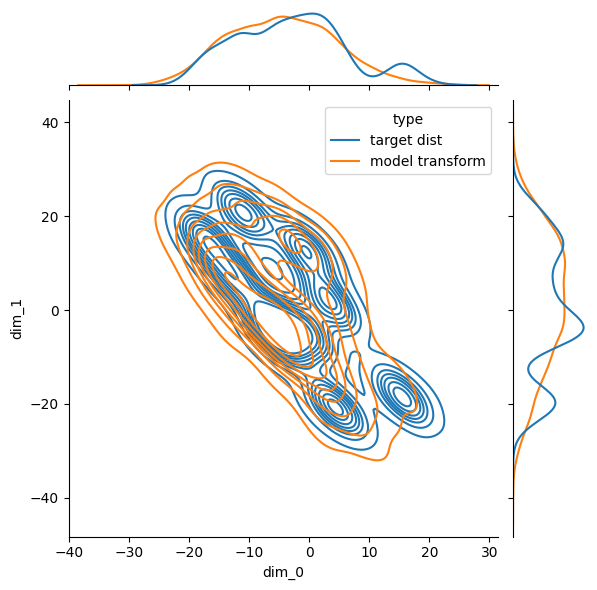

trail: 0 m step: 2 kl_test: 11.287368774414062


  2%|▏         | 100/6000 [00:32<35:31,  2.77it/s]

trail: 0 m step: 3 Loss: 9.319828033447266  L_n: 7.9292755126953125  kld: 0.1390552520751953 KLD1: 7.886987209320068 KLD2: 3.204547643661499


  3%|▎         | 200/6000 [01:04<34:25,  2.81it/s]

trail: 0 m step: 3 Loss: 9.199642181396484  L_n: 7.781566619873047  kld: 0.14180755615234375 KLD1: 7.739935874938965 KLD2: 3.1717607975006104


  5%|▌         | 300/6000 [01:37<34:08,  2.78it/s]

trail: 0 m step: 3 Loss: 9.076353073120117  L_n: 7.588926315307617  kld: 0.14874267578125 KLD1: 7.662342071533203 KLD2: 3.0935537815093994


  7%|▋         | 400/6000 [02:09<33:25,  2.79it/s]

trail: 0 m step: 3 Loss: 8.894432067871094  L_n: 7.533710479736328  kld: 0.13607215881347656 KLD1: 7.723424911499023 KLD2: 3.0657143592834473


  8%|▊         | 500/6000 [02:41<32:43,  2.80it/s]

trail: 0 m step: 3 Loss: 9.069461822509766  L_n: 7.512397766113281  kld: 0.15570640563964844 KLD1: 7.540616035461426 KLD2: 3.090069532394409


 10%|█         | 600/6000 [03:14<32:16,  2.79it/s]

trail: 0 m step: 3 Loss: 9.172513961791992  L_n: 7.582700729370117  kld: 0.1589813232421875 KLD1: 7.431890487670898 KLD2: 3.0894670486450195


 12%|█▏        | 700/6000 [03:46<31:38,  2.79it/s]

trail: 0 m step: 3 Loss: 9.100400924682617  L_n: 7.51905632019043  kld: 0.15813446044921875 KLD1: 7.47717809677124 KLD2: 3.0440421104431152


 13%|█▎        | 800/6000 [04:19<31:06,  2.79it/s]

trail: 0 m step: 3 Loss: 9.125970840454102  L_n: 7.579092025756836  kld: 0.15468788146972656 KLD1: 7.506690502166748 KLD2: 3.065211296081543


 15%|█▌        | 900/6000 [04:51<30:25,  2.79it/s]

trail: 0 m step: 3 Loss: 9.069494247436523  L_n: 7.421125411987305  kld: 0.16483688354492188 KLD1: 7.363916873931885 KLD2: 3.0680761337280273


 17%|█▋        | 1000/6000 [05:23<29:37,  2.81it/s]

trail: 0 m step: 3 Loss: 8.890439987182617  L_n: 7.37724494934082  kld: 0.1513195037841797 KLD1: 7.451134204864502 KLD2: 3.055337905883789


 18%|█▊        | 1100/6000 [05:56<29:16,  2.79it/s]

trail: 0 m step: 3 Loss: 9.024299621582031  L_n: 7.4322357177734375  kld: 0.15920639038085938 KLD1: 7.3239359855651855 KLD2: 3.0486013889312744


 20%|██        | 1200/6000 [06:28<28:41,  2.79it/s]

trail: 0 m step: 3 Loss: 8.941469192504883  L_n: 7.321748733520508  kld: 0.1619720458984375 KLD1: 7.3506317138671875 KLD2: 3.0596909523010254


 22%|██▏       | 1300/6000 [07:00<27:59,  2.80it/s]

trail: 0 m step: 3 Loss: 8.940048217773438  L_n: 7.3424530029296875  kld: 0.159759521484375 KLD1: 7.372018337249756 KLD2: 3.0589330196380615


 23%|██▎       | 1400/6000 [07:33<27:27,  2.79it/s]

trail: 0 m step: 3 Loss: 9.096954345703125  L_n: 7.417457580566406  kld: 0.16794967651367188 KLD1: 7.260990619659424 KLD2: 3.01369571685791


 25%|██▌       | 1500/6000 [08:05<26:51,  2.79it/s]

trail: 0 m step: 3 Loss: 8.926801681518555  L_n: 7.323980331420898  kld: 0.16028213500976562 KLD1: 7.283756256103516 KLD2: 2.9947116374969482


 27%|██▋       | 1600/6000 [08:38<26:16,  2.79it/s]

trail: 0 m step: 3 Loss: 8.969476699829102  L_n: 7.323606491088867  kld: 0.16458702087402344 KLD1: 7.293009281158447 KLD2: 2.997952938079834


 28%|██▊       | 1700/6000 [09:10<25:38,  2.79it/s]

trail: 0 m step: 3 Loss: 8.986162185668945  L_n: 7.413991928100586  kld: 0.15721702575683594 KLD1: 7.355412483215332 KLD2: 3.0434932708740234


 30%|███       | 1800/6000 [09:43<25:05,  2.79it/s]

trail: 0 m step: 3 Loss: 8.869440078735352  L_n: 7.156183242797852  kld: 0.17132568359375 KLD1: 7.159242153167725 KLD2: 3.0006730556488037


 32%|███▏      | 1900/6000 [10:15<24:25,  2.80it/s]

trail: 0 m step: 3 Loss: 8.911466598510742  L_n: 7.236185073852539  kld: 0.1675281524658203 KLD1: 7.30408239364624 KLD2: 3.0323486328125


 33%|███▎      | 2000/6000 [10:47<23:52,  2.79it/s]

trail: 0 m step: 3 Loss: 8.830820083618164  L_n: 7.269636154174805  kld: 0.15611839294433594 KLD1: 7.4087114334106445 KLD2: 3.0246498584747314


 35%|███▌      | 2100/6000 [11:20<23:16,  2.79it/s]

trail: 0 m step: 3 Loss: 8.776161193847656  L_n: 7.1248931884765625  kld: 0.16512680053710938 KLD1: 7.304263114929199 KLD2: 3.021836042404175


 37%|███▋      | 2200/6000 [11:52<22:39,  2.79it/s]

trail: 0 m step: 3 Loss: 8.885126113891602  L_n: 7.260065078735352  kld: 0.162506103515625 KLD1: 7.28262186050415 KLD2: 3.0125374794006348


 38%|███▊      | 2300/6000 [12:24<22:05,  2.79it/s]

trail: 0 m step: 3 Loss: 8.87637710571289  L_n: 7.178226470947266  kld: 0.1698150634765625 KLD1: 7.193151473999023 KLD2: 2.9915449619293213


 40%|████      | 2400/6000 [12:57<21:23,  2.81it/s]

trail: 0 m step: 3 Loss: 8.880373001098633  L_n: 7.251554489135742  kld: 0.16288185119628906 KLD1: 7.2234296798706055 KLD2: 3.011521816253662


 42%|████▏     | 2500/6000 [13:29<20:49,  2.80it/s]

trail: 0 m step: 3 Loss: 8.716907501220703  L_n: 7.133083343505859  kld: 0.15838241577148438 KLD1: 7.2993059158325195 KLD2: 3.0093560218811035


 43%|████▎     | 2600/6000 [14:02<20:12,  2.80it/s]

trail: 0 m step: 3 Loss: 8.902036666870117  L_n: 7.213823318481445  kld: 0.1688213348388672 KLD1: 7.208913803100586 KLD2: 2.9912352561950684


 45%|████▌     | 2700/6000 [14:34<19:42,  2.79it/s]

trail: 0 m step: 3 Loss: 8.838600158691406  L_n: 7.195362091064453  kld: 0.1643238067626953 KLD1: 7.1837639808654785 KLD2: 3.011091470718384


 47%|████▋     | 2800/6000 [15:06<19:06,  2.79it/s]

trail: 0 m step: 3 Loss: 8.982511520385742  L_n: 7.254796981811523  kld: 0.17277145385742188 KLD1: 7.140584945678711 KLD2: 3.0224366188049316


 48%|████▊     | 2900/6000 [15:39<18:29,  2.79it/s]

trail: 0 m step: 3 Loss: 8.907854080200195  L_n: 7.214948654174805  kld: 0.16929054260253906 KLD1: 7.154282569885254 KLD2: 3.010467529296875


 50%|█████     | 3000/6000 [16:11<17:54,  2.79it/s]

trail: 0 m step: 3 Loss: 8.916913986206055  L_n: 7.245866775512695  kld: 0.16710472106933594 KLD1: 7.233646869659424 KLD2: 2.986055374145508


 52%|█████▏    | 3100/6000 [16:44<17:18,  2.79it/s]

trail: 0 m step: 3 Loss: 8.798992156982422  L_n: 7.257148742675781  kld: 0.15418434143066406 KLD1: 7.287191867828369 KLD2: 2.9705166816711426


 53%|█████▎    | 3200/6000 [17:16<16:41,  2.80it/s]

trail: 0 m step: 3 Loss: 8.988922119140625  L_n: 7.255828857421875  kld: 0.173309326171875 KLD1: 7.112127780914307 KLD2: 2.959385395050049


 55%|█████▌    | 3300/6000 [17:48<16:07,  2.79it/s]

trail: 0 m step: 3 Loss: 8.92928695678711  L_n: 7.235847473144531  kld: 0.1693439483642578 KLD1: 7.128230094909668 KLD2: 2.965836524963379


 57%|█████▋    | 3400/6000 [18:21<15:30,  2.79it/s]

trail: 0 m step: 3 Loss: 8.80891227722168  L_n: 7.128252029418945  kld: 0.16806602478027344 KLD1: 7.18113899230957 KLD2: 2.9971868991851807


 58%|█████▊    | 3500/6000 [18:53<14:54,  2.79it/s]

trail: 0 m step: 3 Loss: 8.994161605834961  L_n: 7.315256118774414  kld: 0.1678905487060547 KLD1: 7.1795973777771 KLD2: 3.01206374168396


 60%|██████    | 3600/6000 [19:26<14:20,  2.79it/s]

trail: 0 m step: 3 Loss: 8.78054428100586  L_n: 7.090061187744141  kld: 0.16904830932617188 KLD1: 7.186709403991699 KLD2: 3.0216915607452393


 62%|██████▏   | 3700/6000 [19:58<13:43,  2.79it/s]

trail: 0 m step: 3 Loss: 8.82844352722168  L_n: 7.138895034790039  kld: 0.16895484924316406 KLD1: 7.172135829925537 KLD2: 2.9830446243286133


 63%|██████▎   | 3800/6000 [20:30<13:05,  2.80it/s]

trail: 0 m step: 3 Loss: 8.937698364257812  L_n: 7.317329406738281  kld: 0.16203689575195312 KLD1: 7.225706100463867 KLD2: 2.9735419750213623


 65%|██████▌   | 3900/6000 [21:03<12:30,  2.80it/s]

trail: 0 m step: 3 Loss: 8.796731948852539  L_n: 7.069265365600586  kld: 0.1727466583251953 KLD1: 7.134387493133545 KLD2: 2.9543192386627197


 67%|██████▋   | 4000/6000 [21:35<11:54,  2.80it/s]

trail: 0 m step: 3 Loss: 8.864738464355469  L_n: 7.088615417480469  kld: 0.1776123046875 KLD1: 7.061388969421387 KLD2: 2.9844703674316406


 68%|██████▊   | 4100/6000 [22:08<11:19,  2.80it/s]

trail: 0 m step: 3 Loss: 8.919792175292969  L_n: 7.103996276855469  kld: 0.18157958984375 KLD1: 6.975454330444336 KLD2: 2.9826128482818604


 70%|███████   | 4200/6000 [22:40<10:45,  2.79it/s]

trail: 0 m step: 3 Loss: 8.73825454711914  L_n: 7.074512481689453  kld: 0.16637420654296875 KLD1: 7.219327926635742 KLD2: 2.99116587638855


 72%|███████▏  | 4300/6000 [23:12<10:08,  2.80it/s]

trail: 0 m step: 3 Loss: 8.867660522460938  L_n: 7.185188293457031  kld: 0.16824722290039062 KLD1: 7.164559364318848 KLD2: 3.021183729171753


 73%|███████▎  | 4400/6000 [23:45<09:34,  2.79it/s]

trail: 0 m step: 3 Loss: 8.864948272705078  L_n: 7.1094818115234375  kld: 0.17554664611816406 KLD1: 7.060141086578369 KLD2: 2.981700897216797


 75%|███████▌  | 4500/6000 [24:17<08:57,  2.79it/s]

trail: 0 m step: 3 Loss: 8.9034423828125  L_n: 7.214733123779297  kld: 0.1688709259033203 KLD1: 7.170580863952637 KLD2: 2.9704887866973877


 77%|███████▋  | 4600/6000 [24:49<08:19,  2.80it/s]

trail: 0 m step: 3 Loss: 8.869171142578125  L_n: 7.161750793457031  kld: 0.17074203491210938 KLD1: 7.1090521812438965 KLD2: 3.0105020999908447


 78%|███████▊  | 4700/6000 [25:22<07:46,  2.79it/s]

trail: 0 m step: 3 Loss: 8.733430862426758  L_n: 7.113615036010742  kld: 0.16198158264160156 KLD1: 7.179756164550781 KLD2: 2.9876866340637207


 80%|████████  | 4800/6000 [25:54<07:10,  2.79it/s]

trail: 0 m step: 3 Loss: 8.851276397705078  L_n: 7.202945709228516  kld: 0.16483306884765625 KLD1: 7.258324146270752 KLD2: 2.9838171005249023


 82%|████████▏ | 4900/6000 [26:27<06:33,  2.80it/s]

trail: 0 m step: 3 Loss: 8.856149673461914  L_n: 7.179800033569336  kld: 0.1676349639892578 KLD1: 7.159952163696289 KLD2: 2.9738478660583496


 83%|████████▎ | 5000/6000 [26:59<05:58,  2.79it/s]

trail: 0 m step: 3 Loss: 8.876974105834961  L_n: 7.174112319946289  kld: 0.1702861785888672 KLD1: 7.0860514640808105 KLD2: 2.993098258972168


 85%|████████▌ | 5100/6000 [27:31<05:22,  2.79it/s]

trail: 0 m step: 3 Loss: 8.618249893188477  L_n: 6.990861892700195  kld: 0.16273880004882812 KLD1: 7.190424919128418 KLD2: 3.001898765563965


 87%|████████▋ | 5200/6000 [28:04<04:46,  2.80it/s]

trail: 0 m step: 3 Loss: 8.923446655273438  L_n: 7.1746368408203125  kld: 0.1748809814453125 KLD1: 7.0679779052734375 KLD2: 2.98537278175354


 88%|████████▊ | 5300/6000 [28:36<04:10,  2.79it/s]

trail: 0 m step: 3 Loss: 8.801279067993164  L_n: 7.125616073608398  kld: 0.16756629943847656 KLD1: 7.1748785972595215 KLD2: 2.9701342582702637


 90%|█████████ | 5400/6000 [29:09<03:34,  2.79it/s]

trail: 0 m step: 3 Loss: 8.804611206054688  L_n: 7.144931793212891  kld: 0.1659679412841797 KLD1: 7.157198429107666 KLD2: 2.973078966140747


 92%|█████████▏| 5500/6000 [29:41<02:58,  2.80it/s]

trail: 0 m step: 3 Loss: 8.887596130371094  L_n: 7.132549285888672  kld: 0.1755046844482422 KLD1: 7.119154453277588 KLD2: 2.97389817237854


 93%|█████████▎| 5600/6000 [30:13<02:23,  2.79it/s]

trail: 0 m step: 3 Loss: 8.918811798095703  L_n: 7.176048278808594  kld: 0.17427635192871094 KLD1: 7.0738606452941895 KLD2: 2.9775023460388184


 95%|█████████▌| 5700/6000 [30:46<01:47,  2.79it/s]

trail: 0 m step: 3 Loss: 8.797739028930664  L_n: 7.123201370239258  kld: 0.16745376586914062 KLD1: 7.155375003814697 KLD2: 2.9987125396728516


 97%|█████████▋| 5800/6000 [31:18<01:11,  2.79it/s]

trail: 0 m step: 3 Loss: 8.772972106933594  L_n: 7.093971252441406  kld: 0.16790008544921875 KLD1: 7.151904582977295 KLD2: 2.9704320430755615


 98%|█████████▊| 5900/6000 [31:51<00:35,  2.79it/s]

trail: 0 m step: 3 Loss: 8.83791732788086  L_n: 7.134788513183594  kld: 0.17031288146972656 KLD1: 7.093024730682373 KLD2: 2.9926562309265137


100%|██████████| 6000/6000 [32:23<00:00,  3.09it/s]

trail: 0 m step: 3 Loss: 8.743167877197266  L_n: 6.989551544189453  kld: 0.17536163330078125 KLD1: 7.11013650894165 KLD2: 2.991093635559082



<ipython-input-20-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


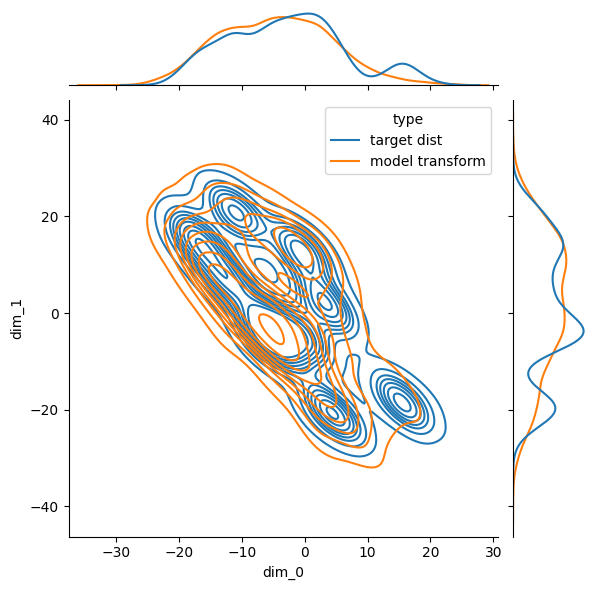

trail: 0 m step: 3 kl_test: 7.190977096557617


  2%|▏         | 100/6000 [00:32<35:27,  2.77it/s]

trail: 0 m step: 4 Loss: 6.095699310302734  L_n: 5.270084381103516  kld: 0.08256149291992188 KLD1: 5.171725749969482 KLD2: 2.386305093765259


  3%|▎         | 200/6000 [01:04<34:16,  2.82it/s]

trail: 0 m step: 4 Loss: 6.015281677246094  L_n: 5.2004241943359375  kld: 0.08148574829101562 KLD1: 5.223818778991699 KLD2: 2.3806729316711426


  5%|▌         | 300/6000 [01:37<34:01,  2.79it/s]

trail: 0 m step: 4 Loss: 5.939983367919922  L_n: 5.085681915283203  kld: 0.08543014526367188 KLD1: 5.141043186187744 KLD2: 2.332695960998535


  7%|▋         | 400/6000 [02:09<33:23,  2.79it/s]

trail: 0 m step: 4 Loss: 5.833961486816406  L_n: 5.0870819091796875  kld: 0.07468795776367188 KLD1: 5.234639644622803 KLD2: 2.3094322681427


  8%|▊         | 500/6000 [02:41<32:44,  2.80it/s]

trail: 0 m step: 4 Loss: 6.011322021484375  L_n: 5.092075347900391  kld: 0.09192466735839844 KLD1: 5.073246479034424 KLD2: 2.3268377780914307


 10%|█         | 600/6000 [03:14<32:12,  2.79it/s]

trail: 0 m step: 4 Loss: 6.020124435424805  L_n: 5.085981369018555  kld: 0.093414306640625 KLD1: 4.9909162521362305 KLD2: 2.3327226638793945


 12%|█▏        | 700/6000 [03:46<31:35,  2.80it/s]

trail: 0 m step: 4 Loss: 6.0170440673828125  L_n: 5.053108215332031  kld: 0.09639358520507812 KLD1: 4.991052150726318 KLD2: 2.2935609817504883


 13%|█▎        | 800/6000 [04:19<30:58,  2.80it/s]

trail: 0 m step: 4 Loss: 5.95189094543457  L_n: 5.053033828735352  kld: 0.08988571166992188 KLD1: 5.036149978637695 KLD2: 2.3127551078796387


 15%|█▌        | 900/6000 [04:51<30:12,  2.81it/s]

trail: 0 m step: 4 Loss: 5.984437942504883  L_n: 5.029485702514648  kld: 0.09549522399902344 KLD1: 5.008719444274902 KLD2: 2.330380916595459


 17%|█▋        | 1000/6000 [05:23<29:43,  2.80it/s]

trail: 0 m step: 4 Loss: 5.821027755737305  L_n: 4.95509147644043  kld: 0.0865936279296875 KLD1: 5.019246578216553 KLD2: 2.3056788444519043


 18%|█▊        | 1100/6000 [05:56<29:12,  2.80it/s]

trail: 0 m step: 4 Loss: 5.941738128662109  L_n: 5.0321807861328125  kld: 0.09095573425292969 KLD1: 4.986342430114746 KLD2: 2.303469181060791


 20%|██        | 1200/6000 [06:28<28:41,  2.79it/s]

trail: 0 m step: 4 Loss: 5.874868392944336  L_n: 4.951482772827148  kld: 0.09233856201171875 KLD1: 4.977960586547852 KLD2: 2.3247764110565186


 22%|██▏       | 1300/6000 [07:00<28:01,  2.79it/s]

trail: 0 m step: 4 Loss: 5.88459587097168  L_n: 4.981924057006836  kld: 0.09026718139648438 KLD1: 5.018095970153809 KLD2: 2.3321995735168457


 23%|██▎       | 1400/6000 [07:33<27:24,  2.80it/s]

trail: 0 m step: 4 Loss: 5.976030349731445  L_n: 5.006258010864258  kld: 0.09697723388671875 KLD1: 4.940075874328613 KLD2: 2.2798826694488525


 25%|██▌       | 1500/6000 [08:05<26:49,  2.80it/s]

trail: 0 m step: 4 Loss: 5.895086288452148  L_n: 4.965044021606445  kld: 0.09300422668457031 KLD1: 4.926384925842285 KLD2: 2.260178565979004


 27%|██▋       | 1600/6000 [08:38<26:03,  2.81it/s]

trail: 0 m step: 4 Loss: 5.90582275390625  L_n: 4.962486267089844  kld: 0.09433364868164062 KLD1: 4.934211730957031 KLD2: 2.2697808742523193


 28%|██▊       | 1700/6000 [09:10<25:40,  2.79it/s]

trail: 0 m step: 4 Loss: 5.9128570556640625  L_n: 5.00823974609375  kld: 0.09046173095703125 KLD1: 5.0147247314453125 KLD2: 2.303870677947998


 30%|███       | 1800/6000 [09:42<25:04,  2.79it/s]

trail: 0 m step: 4 Loss: 5.866704940795898  L_n: 4.844614028930664  kld: 0.10220909118652344 KLD1: 4.869165897369385 KLD2: 2.2672722339630127


 32%|███▏      | 1900/6000 [10:15<24:27,  2.79it/s]

trail: 0 m step: 4 Loss: 5.856840133666992  L_n: 4.880544662475586  kld: 0.09762954711914062 KLD1: 4.9266581535339355 KLD2: 2.3044512271881104


 33%|███▎      | 2000/6000 [10:47<23:50,  2.80it/s]

trail: 0 m step: 4 Loss: 5.847108840942383  L_n: 4.980009078979492  kld: 0.08670997619628906 KLD1: 5.055147647857666 KLD2: 2.2970011234283447


 35%|███▌      | 2100/6000 [11:19<23:13,  2.80it/s]

trail: 0 m step: 4 Loss: 5.7639312744140625  L_n: 4.804191589355469  kld: 0.09597396850585938 KLD1: 4.939558506011963 KLD2: 2.299806594848633


 37%|███▋      | 2200/6000 [11:52<22:32,  2.81it/s]

trail: 0 m step: 4 Loss: 5.837741851806641  L_n: 4.931636810302734  kld: 0.09061050415039062 KLD1: 4.985750675201416 KLD2: 2.2890403270721436


 38%|███▊      | 2300/6000 [12:24<21:59,  2.80it/s]

trail: 0 m step: 4 Loss: 5.855325698852539  L_n: 4.85322380065918  kld: 0.10021018981933594 KLD1: 4.847306251525879 KLD2: 2.2662761211395264


 40%|████      | 2400/6000 [12:57<21:30,  2.79it/s]

trail: 0 m step: 4 Loss: 5.836971282958984  L_n: 4.8991851806640625  kld: 0.09377861022949219 KLD1: 4.905703544616699 KLD2: 2.2830426692962646


 42%|████▏     | 2500/6000 [13:29<20:49,  2.80it/s]

trail: 0 m step: 4 Loss: 5.749382019042969  L_n: 4.861759185791016  kld: 0.08876228332519531 KLD1: 4.964560031890869 KLD2: 2.2842483520507812


 43%|████▎     | 2600/6000 [14:01<20:15,  2.80it/s]

trail: 0 m step: 4 Loss: 5.902116775512695  L_n: 4.906576156616211  kld: 0.09955406188964844 KLD1: 4.843923091888428 KLD2: 2.262688636779785


 45%|████▌     | 2700/6000 [14:34<19:39,  2.80it/s]

trail: 0 m step: 4 Loss: 5.842805862426758  L_n: 4.889322280883789  kld: 0.09534835815429688 KLD1: 4.867022514343262 KLD2: 2.2829785346984863


 47%|████▋     | 2800/6000 [15:06<19:04,  2.80it/s]

trail: 0 m step: 4 Loss: 5.937211990356445  L_n: 4.92683219909668  kld: 0.10103797912597656 KLD1: 4.820888042449951 KLD2: 2.2938709259033203


 48%|████▊     | 2900/6000 [15:39<18:28,  2.80it/s]

trail: 0 m step: 4 Loss: 5.865522384643555  L_n: 4.895788192749023  kld: 0.09697341918945312 KLD1: 4.856938362121582 KLD2: 2.2899391651153564


 50%|█████     | 3000/6000 [16:11<17:50,  2.80it/s]

trail: 0 m step: 4 Loss: 5.881635665893555  L_n: 4.935056686401367  kld: 0.09465789794921875 KLD1: 4.931787967681885 KLD2: 2.264233112335205


 52%|█████▏    | 3100/6000 [16:43<17:17,  2.80it/s]

trail: 0 m step: 4 Loss: 5.820804595947266  L_n: 4.95782470703125  kld: 0.08629798889160156 KLD1: 4.971567630767822 KLD2: 2.2488961219787598


 53%|█████▎    | 3200/6000 [17:16<16:37,  2.81it/s]

trail: 0 m step: 4 Loss: 5.914508819580078  L_n: 4.908134460449219  kld: 0.10063743591308594 KLD1: 4.8227219581604 KLD2: 2.239359140396118


 55%|█████▌    | 3300/6000 [17:48<16:05,  2.80it/s]

trail: 0 m step: 4 Loss: 5.889007568359375  L_n: 4.934093475341797  kld: 0.09549140930175781 KLD1: 4.8631110191345215 KLD2: 2.249058485031128


 57%|█████▋    | 3400/6000 [18:20<15:33,  2.79it/s]

trail: 0 m step: 4 Loss: 5.82060432434082  L_n: 4.848714828491211  kld: 0.09718894958496094 KLD1: 4.846530914306641 KLD2: 2.271502733230591


 58%|█████▊    | 3500/6000 [18:53<14:52,  2.80it/s]

trail: 0 m step: 4 Loss: 5.968692779541016  L_n: 4.9966888427734375  kld: 0.09720039367675781 KLD1: 4.898110866546631 KLD2: 2.2850584983825684


 60%|██████    | 3600/6000 [19:25<14:20,  2.79it/s]

trail: 0 m step: 4 Loss: 5.774349212646484  L_n: 4.801506042480469  kld: 0.09728431701660156 KLD1: 4.873464107513428 KLD2: 2.2994534969329834


 62%|██████▏   | 3700/6000 [19:57<13:42,  2.80it/s]

trail: 0 m step: 4 Loss: 5.831005096435547  L_n: 4.859859466552734  kld: 0.09711456298828125 KLD1: 4.862112998962402 KLD2: 2.2661781311035156


 63%|██████▎   | 3800/6000 [20:30<13:05,  2.80it/s]

trail: 0 m step: 4 Loss: 5.907567977905273  L_n: 4.975332260131836  kld: 0.09322357177734375 KLD1: 4.888164520263672 KLD2: 2.2556419372558594


 65%|██████▌   | 3900/6000 [21:02<12:27,  2.81it/s]

trail: 0 m step: 4 Loss: 5.785921096801758  L_n: 4.757211685180664  kld: 0.10287094116210938 KLD1: 4.831535339355469 KLD2: 2.2364237308502197


 67%|██████▋   | 4000/6000 [21:34<11:56,  2.79it/s]

trail: 0 m step: 4 Loss: 5.847846984863281  L_n: 4.8220367431640625  kld: 0.10258102416992188 KLD1: 4.825159072875977 KLD2: 2.2668280601501465


 68%|██████▊   | 4100/6000 [22:07<11:20,  2.79it/s]

trail: 0 m step: 4 Loss: 5.866804122924805  L_n: 4.799566268920898  kld: 0.10672378540039062 KLD1: 4.741386413574219 KLD2: 2.2627370357513428


 70%|███████   | 4200/6000 [22:39<10:40,  2.81it/s]

trail: 0 m step: 4 Loss: 5.692100524902344  L_n: 4.734077453613281  kld: 0.09580230712890625 KLD1: 4.873152732849121 KLD2: 2.2696480751037598


 72%|███████▏  | 4300/6000 [23:12<10:05,  2.81it/s]

trail: 0 m step: 4 Loss: 5.843694686889648  L_n: 4.875734329223633  kld: 0.09679603576660156 KLD1: 4.857810020446777 KLD2: 2.3003592491149902


 73%|███████▎  | 4400/6000 [23:44<09:31,  2.80it/s]

trail: 0 m step: 4 Loss: 5.835704803466797  L_n: 4.814491271972656  kld: 0.10212135314941406 KLD1: 4.7708420753479 KLD2: 2.2664947509765625


 75%|███████▌  | 4500/6000 [24:16<08:56,  2.79it/s]

trail: 0 m step: 4 Loss: 5.882312774658203  L_n: 4.91351318359375  kld: 0.09687995910644531 KLD1: 4.836940288543701 KLD2: 2.2557456493377686


 77%|███████▋  | 4600/6000 [24:49<08:21,  2.79it/s]

trail: 0 m step: 4 Loss: 5.850307464599609  L_n: 4.866058349609375  kld: 0.09842491149902344 KLD1: 4.818467617034912 KLD2: 2.2913436889648438


 78%|███████▊  | 4700/6000 [25:21<07:46,  2.79it/s]

trail: 0 m step: 4 Loss: 5.730171203613281  L_n: 4.828948974609375  kld: 0.09012222290039062 KLD1: 4.898301124572754 KLD2: 2.2680821418762207


 80%|████████  | 4800/6000 [25:54<07:09,  2.80it/s]

trail: 0 m step: 4 Loss: 5.81578254699707  L_n: 4.881010055541992  kld: 0.09347724914550781 KLD1: 4.914626121520996 KLD2: 2.265645742416382


 82%|████████▏ | 4900/6000 [26:26<06:32,  2.80it/s]

trail: 0 m step: 4 Loss: 5.849018096923828  L_n: 4.8865509033203125  kld: 0.09624671936035156 KLD1: 4.825175762176514 KLD2: 2.2567007541656494


 83%|████████▎ | 5000/6000 [26:58<05:58,  2.79it/s]

trail: 0 m step: 4 Loss: 5.83570671081543  L_n: 4.871332168579102  kld: 0.09643745422363281 KLD1: 4.831608295440674 KLD2: 2.2765300273895264


 85%|████████▌ | 5100/6000 [27:31<05:21,  2.80it/s]

trail: 0 m step: 4 Loss: 5.669734954833984  L_n: 4.734771728515625  kld: 0.09349632263183594 KLD1: 4.8703179359436035 KLD2: 2.279362201690674


 87%|████████▋ | 5200/6000 [28:03<04:46,  2.79it/s]

trail: 0 m step: 4 Loss: 5.885795593261719  L_n: 4.874919891357422  kld: 0.10108757019042969 KLD1: 4.777196884155273 KLD2: 2.2662856578826904


 88%|████████▊ | 5300/6000 [28:35<04:10,  2.79it/s]

trail: 0 m step: 4 Loss: 5.778100967407227  L_n: 4.828775405883789  kld: 0.09493255615234375 KLD1: 4.930456161499023 KLD2: 2.253736972808838


 90%|█████████ | 5400/6000 [29:08<03:33,  2.80it/s]

trail: 0 m step: 4 Loss: 5.785844802856445  L_n: 4.834383010864258  kld: 0.09514617919921875 KLD1: 4.853006839752197 KLD2: 2.2539854049682617


 92%|█████████▏| 5500/6000 [29:40<02:58,  2.80it/s]

trail: 0 m step: 4 Loss: 5.880029678344727  L_n: 4.86060905456543  kld: 0.10194206237792969 KLD1: 4.844747066497803 KLD2: 2.2590723037719727


 93%|█████████▎| 5600/6000 [30:13<02:23,  2.79it/s]

trail: 0 m step: 4 Loss: 5.885465621948242  L_n: 4.893510818481445  kld: 0.09919548034667969 KLD1: 4.845251560211182 KLD2: 2.266162395477295


 95%|█████████▌| 5700/6000 [30:45<01:47,  2.79it/s]

trail: 0 m step: 4 Loss: 5.799129486083984  L_n: 4.847858428955078  kld: 0.09512710571289062 KLD1: 4.849653720855713 KLD2: 2.282721757888794


 97%|█████████▋| 5800/6000 [31:17<01:11,  2.80it/s]

trail: 0 m step: 4 Loss: 5.768198013305664  L_n: 4.826749801635742  kld: 0.09414482116699219 KLD1: 4.862901210784912 KLD2: 2.2532896995544434


 98%|█████████▊| 5900/6000 [31:50<00:35,  2.79it/s]

trail: 0 m step: 4 Loss: 5.851806640625  L_n: 4.872516632080078  kld: 0.09792900085449219 KLD1: 4.825938701629639 KLD2: 2.273881196975708


100%|██████████| 6000/6000 [32:22<00:00,  3.09it/s]

trail: 0 m step: 4 Loss: 5.793718338012695  L_n: 4.797643661499023  kld: 0.09960746765136719 KLD1: 4.835421085357666 KLD2: 2.271266460418701



<ipython-input-20-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


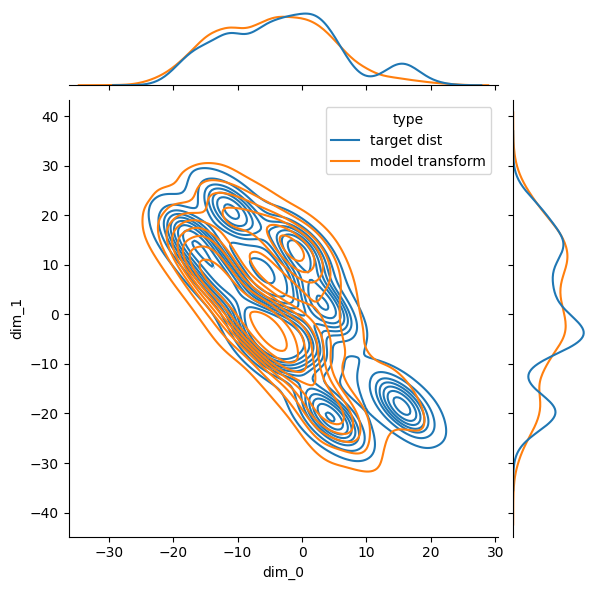

trail: 0 m step: 4 kl_test: 4.869524002075195


  2%|▏         | 100/6000 [00:32<35:27,  2.77it/s]

trail: 0 m step: 5 Loss: 4.221643447875977  L_n: 3.6965503692626953  kld: 0.052509307861328125 KLD1: 3.6329381465911865 KLD2: 1.8367433547973633


  3%|▎         | 200/6000 [01:04<34:30,  2.80it/s]

trail: 0 m step: 5 Loss: 4.172300338745117  L_n: 3.6498966217041016  kld: 0.05224037170410156 KLD1: 3.690107822418213 KLD2: 1.840781569480896


  5%|▌         | 300/6000 [01:37<33:59,  2.79it/s]

trail: 0 m step: 5 Loss: 4.159168243408203  L_n: 3.6044158935546875  kld: 0.05547523498535156 KLD1: 3.6264448165893555 KLD2: 1.8018215894699097


  7%|▋         | 400/6000 [02:09<33:33,  2.78it/s]

trail: 0 m step: 5 Loss: 4.018999099731445  L_n: 3.578725814819336  kld: 0.04402732849121094 KLD1: 3.722527265548706 KLD2: 1.7809518575668335


  8%|▊         | 500/6000 [02:42<32:42,  2.80it/s]

trail: 0 m step: 5 Loss: 4.21931266784668  L_n: 3.629789352416992  kld: 0.05895233154296875 KLD1: 3.6243343353271484 KLD2: 1.8002526760101318


 10%|█         | 600/6000 [03:14<32:12,  2.79it/s]

trail: 0 m step: 5 Loss: 4.21856689453125  L_n: 3.6311798095703125  kld: 0.05873870849609375 KLD1: 3.5427074432373047 KLD2: 1.817219853401184


 12%|█▏        | 700/6000 [03:47<31:32,  2.80it/s]

trail: 0 m step: 5 Loss: 4.183441162109375  L_n: 3.5830459594726562  kld: 0.060039520263671875 KLD1: 3.544487476348877 KLD2: 1.7797995805740356


 13%|█▎        | 800/6000 [04:19<31:03,  2.79it/s]

trail: 0 m step: 5 Loss: 4.148168563842773  L_n: 3.580923080444336  kld: 0.05672454833984375 KLD1: 3.578815460205078 KLD2: 1.7889388799667358


 15%|█▌        | 900/6000 [04:52<30:27,  2.79it/s]

trail: 0 m step: 5 Loss: 4.167680740356445  L_n: 3.561391830444336  kld: 0.06062889099121094 KLD1: 3.5246713161468506 KLD2: 1.8017557859420776


 17%|█▋        | 1000/6000 [05:24<29:46,  2.80it/s]

trail: 0 m step: 5 Loss: 4.07127571105957  L_n: 3.540212631225586  kld: 0.05310630798339844 KLD1: 3.581587314605713 KLD2: 1.7879807949066162


 18%|█▊        | 1100/6000 [05:56<29:17,  2.79it/s]

trail: 0 m step: 5 Loss: 4.116296768188477  L_n: 3.537454605102539  kld: 0.05788421630859375 KLD1: 3.5664515495300293 KLD2: 1.780361294746399


 20%|██        | 1200/6000 [06:29<28:38,  2.79it/s]

trail: 0 m step: 5 Loss: 4.08036994934082  L_n: 3.4935359954833984  kld: 0.05868339538574219 KLD1: 3.5304436683654785 KLD2: 1.801910638809204


 22%|██▏       | 1300/6000 [07:01<28:02,  2.79it/s]

trail: 0 m step: 5 Loss: 4.113006591796875  L_n: 3.5536956787109375  kld: 0.05593109130859375 KLD1: 3.550642967224121 KLD2: 1.8153713941574097


 23%|██▎       | 1400/6000 [07:34<27:25,  2.80it/s]

trail: 0 m step: 5 Loss: 4.184762954711914  L_n: 3.567831039428711  kld: 0.06169319152832031 KLD1: 3.5067076683044434 KLD2: 1.7576003074645996


 25%|██▌       | 1500/6000 [08:06<26:50,  2.79it/s]

trail: 0 m step: 5 Loss: 4.08372688293457  L_n: 3.496835708618164  kld: 0.058689117431640625 KLD1: 3.526571750640869 KLD2: 1.747772216796875


 27%|██▋       | 1600/6000 [08:38<26:12,  2.80it/s]

trail: 0 m step: 5 Loss: 4.108938217163086  L_n: 3.516420364379883  kld: 0.05925178527832031 KLD1: 3.5064709186553955 KLD2: 1.7563645839691162


 28%|██▊       | 1700/6000 [09:11<25:38,  2.80it/s]

trail: 0 m step: 5 Loss: 4.122032165527344  L_n: 3.5679473876953125  kld: 0.055408477783203125 KLD1: 3.5860538482666016 KLD2: 1.7946122884750366


 30%|███       | 1800/6000 [09:43<25:00,  2.80it/s]

trail: 0 m step: 5 Loss: 4.096845626831055  L_n: 3.4519710540771484  kld: 0.06448745727539062 KLD1: 3.4743218421936035 KLD2: 1.7614284753799438


 32%|███▏      | 1900/6000 [10:16<24:25,  2.80it/s]

trail: 0 m step: 5 Loss: 4.098482131958008  L_n: 3.5037899017333984  kld: 0.05946922302246094 KLD1: 3.5335347652435303 KLD2: 1.7908663749694824


 33%|███▎      | 2000/6000 [10:48<23:56,  2.78it/s]

trail: 0 m step: 5 Loss: 4.077487945556641  L_n: 3.5609397888183594  kld: 0.051654815673828125 KLD1: 3.5799264907836914 KLD2: 1.7795698642730713


 35%|███▌      | 2100/6000 [11:21<23:21,  2.78it/s]

trail: 0 m step: 5 Loss: 4.053199768066406  L_n: 3.4443931579589844  kld: 0.06088066101074219 KLD1: 3.522303819656372 KLD2: 1.7799608707427979


 37%|███▋      | 2200/6000 [11:53<22:43,  2.79it/s]

trail: 0 m step: 5 Loss: 4.061552047729492  L_n: 3.497091293334961  kld: 0.056446075439453125 KLD1: 3.537461519241333 KLD2: 1.7684657573699951


 38%|███▊      | 2300/6000 [12:25<22:08,  2.79it/s]

trail: 0 m step: 5 Loss: 4.077913284301758  L_n: 3.454916000366211  kld: 0.06229972839355469 KLD1: 3.460330009460449 KLD2: 1.752296805381775


 40%|████      | 2400/6000 [12:58<21:26,  2.80it/s]

trail: 0 m step: 5 Loss: 4.056272506713867  L_n: 3.4760570526123047  kld: 0.05802154541015625 KLD1: 3.494731903076172 KLD2: 1.7712159156799316


 42%|████▏     | 2500/6000 [13:30<20:57,  2.78it/s]

trail: 0 m step: 5 Loss: 4.006006240844727  L_n: 3.4609813690185547  kld: 0.05450248718261719 KLD1: 3.499207019805908 KLD2: 1.7719165086746216


 43%|████▎     | 2600/6000 [14:03<20:20,  2.79it/s]

trail: 0 m step: 5 Loss: 4.127344131469727  L_n: 3.5090770721435547  kld: 0.06182670593261719 KLD1: 3.4325170516967773 KLD2: 1.7548538446426392


 45%|████▌     | 2700/6000 [14:35<19:40,  2.79it/s]

trail: 0 m step: 5 Loss: 4.096242904663086  L_n: 3.516084671020508  kld: 0.05801582336425781 KLD1: 3.4621613025665283 KLD2: 1.7748088836669922


 47%|████▋     | 2800/6000 [15:08<19:09,  2.78it/s]

trail: 0 m step: 5 Loss: 4.170307159423828  L_n: 3.5441055297851562  kld: 0.06262016296386719 KLD1: 3.439553737640381 KLD2: 1.787458896636963


 48%|████▊     | 2900/6000 [15:40<18:30,  2.79it/s]

trail: 0 m step: 5 Loss: 4.11094856262207  L_n: 3.5037059783935547  kld: 0.06072425842285156 KLD1: 3.469775676727295 KLD2: 1.7840981483459473


 50%|█████     | 3000/6000 [16:12<17:55,  2.79it/s]

trail: 0 m step: 5 Loss: 4.108180999755859  L_n: 3.50860595703125  kld: 0.05995750427246094 KLD1: 3.498915433883667 KLD2: 1.7555241584777832


 52%|█████▏    | 3100/6000 [16:45<17:17,  2.80it/s]

trail: 0 m step: 5 Loss: 4.060945510864258  L_n: 3.5329151153564453  kld: 0.05280303955078125 KLD1: 3.5485193729400635 KLD2: 1.7402212619781494


 53%|█████▎    | 3200/6000 [17:17<16:41,  2.80it/s]

trail: 0 m step: 5 Loss: 4.1565704345703125  L_n: 3.502483367919922  kld: 0.06540870666503906 KLD1: 3.3960554599761963 KLD2: 1.7352333068847656


 55%|█████▌    | 3300/6000 [17:50<16:07,  2.79it/s]

trail: 0 m step: 5 Loss: 4.106456756591797  L_n: 3.530017852783203  kld: 0.057643890380859375 KLD1: 3.497465133666992 KLD2: 1.748392939567566


 57%|█████▋    | 3400/6000 [18:22<15:32,  2.79it/s]

trail: 0 m step: 5 Loss: 4.052312850952148  L_n: 3.435628890991211  kld: 0.06166839599609375 KLD1: 3.4277124404907227 KLD2: 1.7657967805862427


 58%|█████▊    | 3500/6000 [18:54<14:58,  2.78it/s]

trail: 0 m step: 5 Loss: 4.172672271728516  L_n: 3.5680809020996094  kld: 0.060459136962890625 KLD1: 3.48503041267395 KLD2: 1.778768539428711


 60%|██████    | 3600/6000 [19:27<14:19,  2.79it/s]

trail: 0 m step: 5 Loss: 4.009180068969727  L_n: 3.398275375366211  kld: 0.06109046936035156 KLD1: 3.4622209072113037 KLD2: 1.7905629873275757


 62%|██████▏   | 3700/6000 [19:59<13:43,  2.79it/s]

trail: 0 m step: 5 Loss: 4.0919342041015625  L_n: 3.487895965576172  kld: 0.06040382385253906 KLD1: 3.4731099605560303 KLD2: 1.7605541944503784


 63%|██████▎   | 3800/6000 [20:32<13:08,  2.79it/s]

trail: 0 m step: 5 Loss: 4.122201919555664  L_n: 3.5610218048095703  kld: 0.056118011474609375 KLD1: 3.483182430267334 KLD2: 1.75264310836792


 65%|██████▌   | 3900/6000 [21:04<12:32,  2.79it/s]

trail: 0 m step: 5 Loss: 4.052801132202148  L_n: 3.4034252166748047  kld: 0.06493759155273438 KLD1: 3.4629967212677 KLD2: 1.72894287109375


 67%|██████▋   | 4000/6000 [21:37<11:55,  2.80it/s]

trail: 0 m step: 5 Loss: 4.0697479248046875  L_n: 3.4222984313964844  kld: 0.06474494934082031 KLD1: 3.4581291675567627 KLD2: 1.7567366361618042


 68%|██████▊   | 4100/6000 [22:09<11:20,  2.79it/s]

trail: 0 m step: 5 Loss: 4.094028472900391  L_n: 3.423900604248047  kld: 0.06701278686523438 KLD1: 3.4068682193756104 KLD2: 1.754923939704895


 70%|███████   | 4200/6000 [22:41<10:45,  2.79it/s]

trail: 0 m step: 5 Loss: 3.9589672088623047  L_n: 3.3768062591552734  kld: 0.058216094970703125 KLD1: 3.467189073562622 KLD2: 1.7654118537902832


 72%|███████▏  | 4300/6000 [23:14<10:09,  2.79it/s]

trail: 0 m step: 5 Loss: 4.083095550537109  L_n: 3.4912643432617188  kld: 0.05918312072753906 KLD1: 3.4867959022521973 KLD2: 1.7910839319229126


 73%|███████▎  | 4400/6000 [23:46<09:32,  2.79it/s]

trail: 0 m step: 5 Loss: 4.072298049926758  L_n: 3.439268112182617  kld: 0.06330299377441406 KLD1: 3.4196841716766357 KLD2: 1.7559757232666016


 75%|███████▌  | 4500/6000 [24:19<08:57,  2.79it/s]

trail: 0 m step: 5 Loss: 4.1293182373046875  L_n: 3.5261383056640625  kld: 0.0603179931640625 KLD1: 3.4557716846466064 KLD2: 1.7467917203903198


 77%|███████▋  | 4600/6000 [24:51<08:20,  2.80it/s]

trail: 0 m step: 5 Loss: 4.081747055053711  L_n: 3.4716625213623047  kld: 0.061008453369140625 KLD1: 3.4416046142578125 KLD2: 1.7791423797607422


 78%|███████▊  | 4700/6000 [25:24<07:45,  2.79it/s]

trail: 0 m step: 5 Loss: 3.9796581268310547  L_n: 3.436521530151367  kld: 0.05431365966796875 KLD1: 3.513033151626587 KLD2: 1.7607104778289795


 80%|████████  | 4800/6000 [25:56<07:10,  2.79it/s]

trail: 0 m step: 5 Loss: 4.047849655151367  L_n: 3.4755306243896484  kld: 0.057231903076171875 KLD1: 3.509023427963257 KLD2: 1.7584987878799438


 82%|████████▏ | 4900/6000 [26:28<06:34,  2.79it/s]

trail: 0 m step: 5 Loss: 4.077352523803711  L_n: 3.476308822631836  kld: 0.0601043701171875 KLD1: 3.4326624870300293 KLD2: 1.7487820386886597


 83%|████████▎ | 5000/6000 [27:01<05:58,  2.79it/s]

trail: 0 m step: 5 Loss: 4.0872344970703125  L_n: 3.4796295166015625  kld: 0.060760498046875 KLD1: 3.446798801422119 KLD2: 1.7640372514724731


 85%|████████▌ | 5100/6000 [27:33<05:23,  2.79it/s]

trail: 0 m step: 5 Loss: 3.9463462829589844  L_n: 3.3778419494628906  kld: 0.056850433349609375 KLD1: 3.4761595726013184 KLD2: 1.7707819938659668


 87%|████████▋ | 5200/6000 [28:06<04:47,  2.79it/s]

trail: 0 m step: 5 Loss: 4.106782913208008  L_n: 3.467611312866211  kld: 0.06391716003417969 KLD1: 3.4120585918426514 KLD2: 1.7535897493362427


 88%|████████▊ | 5300/6000 [28:38<04:10,  2.79it/s]

trail: 0 m step: 5 Loss: 4.015880584716797  L_n: 3.419300079345703  kld: 0.059658050537109375 KLD1: 3.499176502227783 KLD2: 1.7462495565414429


 90%|█████████ | 5400/6000 [29:10<03:35,  2.79it/s]

trail: 0 m step: 5 Loss: 4.022089004516602  L_n: 3.4405956268310547  kld: 0.05814933776855469 KLD1: 3.457789659500122 KLD2: 1.7462130784988403


 92%|█████████▏| 5500/6000 [29:43<02:59,  2.79it/s]

trail: 0 m step: 5 Loss: 4.094793319702148  L_n: 3.4493274688720703  kld: 0.06454658508300781 KLD1: 3.437084197998047 KLD2: 1.7567403316497803


 93%|█████████▎| 5600/6000 [30:15<02:23,  2.78it/s]

trail: 0 m step: 5 Loss: 4.085050582885742  L_n: 3.476530075073242  kld: 0.06085205078125 KLD1: 3.4883742332458496 KLD2: 1.7615535259246826


 95%|█████████▌| 5700/6000 [30:48<01:47,  2.79it/s]

trail: 0 m step: 5 Loss: 4.0413665771484375  L_n: 3.4539794921875  kld: 0.05873870849609375 KLD1: 3.4463865756988525 KLD2: 1.7719507217407227


 97%|█████████▋| 5800/6000 [31:20<01:11,  2.79it/s]

trail: 0 m step: 5 Loss: 4.0174713134765625  L_n: 3.446563720703125  kld: 0.05709075927734375 KLD1: 3.4793741703033447 KLD2: 1.7489807605743408


 98%|█████████▊| 5900/6000 [31:53<00:35,  2.80it/s]

trail: 0 m step: 5 Loss: 4.051031112670898  L_n: 3.4430065155029297  kld: 0.060802459716796875 KLD1: 3.421281099319458 KLD2: 1.7673232555389404


100%|██████████| 6000/6000 [32:25<00:00,  3.08it/s]

trail: 0 m step: 5 Loss: 4.022026062011719  L_n: 3.401813507080078  kld: 0.06202125549316406 KLD1: 3.441082715988159 KLD2: 1.764675498008728



<ipython-input-20-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


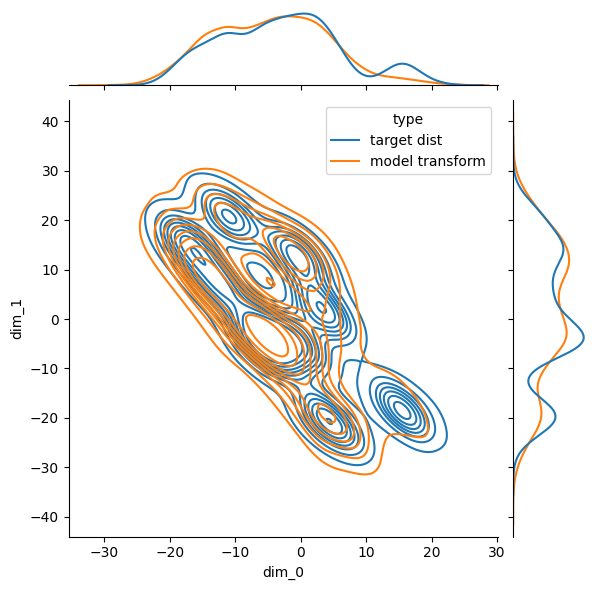

trail: 0 m step: 5 kl_test: 3.454469680786133


  2%|▏         | 100/6000 [00:32<35:28,  2.77it/s]

trail: 0 m step: 6 Loss: 3.0722103118896484  L_n: 2.7228031158447266  kld: 0.03494071960449219 KLD1: 2.6955010890960693 KLD2: 1.4460433721542358


  3%|▎         | 200/6000 [01:04<34:25,  2.81it/s]

trail: 0 m step: 6 Loss: 3.0520153045654297  L_n: 2.7071285247802734  kld: 0.034488677978515625 KLD1: 2.7100563049316406 KLD2: 1.4507369995117188


  5%|▌         | 300/6000 [01:37<33:54,  2.80it/s]

trail: 0 m step: 6 Loss: 3.027090072631836  L_n: 2.6527156829833984  kld: 0.03743743896484375 KLD1: 2.689105272293091 KLD2: 1.4143517017364502


  7%|▋         | 400/6000 [02:09<33:19,  2.80it/s]

trail: 0 m step: 6 Loss: 2.921243667602539  L_n: 2.6501903533935547  kld: 0.027105331420898438 KLD1: 2.7683157920837402 KLD2: 1.4090218544006348


  8%|▊         | 500/6000 [02:41<32:48,  2.79it/s]

trail: 0 m step: 6 Loss: 3.040355682373047  L_n: 2.6543846130371094  kld: 0.03859710693359375 KLD1: 2.6265368461608887 KLD2: 1.420985221862793


 10%|█         | 600/6000 [03:14<32:10,  2.80it/s]

trail: 0 m step: 6 Loss: 3.0564117431640625  L_n: 2.6354408264160156  kld: 0.04209709167480469 KLD1: 2.599550247192383 KLD2: 1.4212497472763062


 12%|█▏        | 700/6000 [03:46<31:37,  2.79it/s]

trail: 0 m step: 6 Loss: 3.0369338989257812  L_n: 2.634693145751953  kld: 0.04022407531738281 KLD1: 2.6089024543762207 KLD2: 1.400398850440979


 13%|█▎        | 800/6000 [04:19<30:55,  2.80it/s]

trail: 0 m step: 6 Loss: 2.9955806732177734  L_n: 2.5851001739501953  kld: 0.04104804992675781 KLD1: 2.6345412731170654 KLD2: 1.4024502038955688


 15%|█▌        | 900/6000 [04:51<30:26,  2.79it/s]

trail: 0 m step: 6 Loss: 3.068593978881836  L_n: 2.6658763885498047  kld: 0.040271759033203125 KLD1: 2.622406482696533 KLD2: 1.4210951328277588


 17%|█▋        | 1000/6000 [05:23<29:46,  2.80it/s]

trail: 0 m step: 6 Loss: 2.943042755126953  L_n: 2.5826492309570312  kld: 0.03603935241699219 KLD1: 2.6309845447540283 KLD2: 1.4054712057113647


 18%|█▊        | 1100/6000 [05:56<29:15,  2.79it/s]

trail: 0 m step: 6 Loss: 2.999744415283203  L_n: 2.5978660583496094  kld: 0.040187835693359375 KLD1: 2.608405828475952 KLD2: 1.4066513776779175


 20%|██        | 1200/6000 [06:28<28:37,  2.79it/s]

trail: 0 m step: 6 Loss: 2.969572067260742  L_n: 2.600595474243164  kld: 0.03689765930175781 KLD1: 2.585268020629883 KLD2: 1.4298367500305176


 22%|██▏       | 1300/6000 [07:00<27:47,  2.82it/s]

trail: 0 m step: 6 Loss: 2.987293243408203  L_n: 2.6168670654296875  kld: 0.03704261779785156 KLD1: 2.6235010623931885 KLD2: 1.4391649961471558


 23%|██▎       | 1400/6000 [07:33<27:24,  2.80it/s]

trail: 0 m step: 6 Loss: 3.004335403442383  L_n: 2.5948657989501953  kld: 0.04094696044921875 KLD1: 2.619274854660034 KLD2: 1.3902125358581543


 25%|██▌       | 1500/6000 [08:05<26:49,  2.80it/s]

trail: 0 m step: 6 Loss: 2.9647598266601562  L_n: 2.5704917907714844  kld: 0.03942680358886719 KLD1: 2.573364496231079 KLD2: 1.377511739730835


 27%|██▋       | 1600/6000 [08:37<26:12,  2.80it/s]

trail: 0 m step: 6 Loss: 2.963703155517578  L_n: 2.5599746704101562  kld: 0.04037284851074219 KLD1: 2.5785255432128906 KLD2: 1.3901481628417969


 28%|██▊       | 1700/6000 [09:10<25:35,  2.80it/s]

trail: 0 m step: 6 Loss: 3.0340347290039062  L_n: 2.6541099548339844  kld: 0.03799247741699219 KLD1: 2.6491246223449707 KLD2: 1.4133542776107788


 30%|███       | 1800/6000 [09:42<25:02,  2.79it/s]

trail: 0 m step: 6 Loss: 2.950033187866211  L_n: 2.5235118865966797  kld: 0.042652130126953125 KLD1: 2.5142359733581543 KLD2: 1.3931456804275513


 32%|███▏      | 1900/6000 [10:15<24:27,  2.79it/s]

trail: 0 m step: 6 Loss: 2.976757049560547  L_n: 2.589794158935547  kld: 0.0386962890625 KLD1: 2.60249400138855 KLD2: 1.4217529296875


 33%|███▎      | 2000/6000 [10:47<23:52,  2.79it/s]

trail: 0 m step: 6 Loss: 2.945955276489258  L_n: 2.6145153045654297  kld: 0.03314399719238281 KLD1: 2.64787220954895 KLD2: 1.4117594957351685


 35%|███▌      | 2100/6000 [11:19<23:16,  2.79it/s]

trail: 0 m step: 6 Loss: 2.949800491333008  L_n: 2.5449275970458984  kld: 0.04048728942871094 KLD1: 2.6120712757110596 KLD2: 1.4131122827529907


 37%|███▋      | 2200/6000 [11:52<22:33,  2.81it/s]

trail: 0 m step: 6 Loss: 2.9778785705566406  L_n: 2.6120681762695312  kld: 0.03658103942871094 KLD1: 2.6220829486846924 KLD2: 1.402046799659729


 38%|███▊      | 2300/6000 [12:24<22:01,  2.80it/s]

trail: 0 m step: 6 Loss: 2.93768310546875  L_n: 2.5297203063964844  kld: 0.04079627990722656 KLD1: 2.575079917907715 KLD2: 1.3854423761367798


 40%|████      | 2400/6000 [12:57<21:27,  2.80it/s]

trail: 0 m step: 6 Loss: 2.9409008026123047  L_n: 2.5571422576904297  kld: 0.0383758544921875 KLD1: 2.582298517227173 KLD2: 1.4020357131958008


 42%|████▏     | 2500/6000 [13:29<20:54,  2.79it/s]

trail: 0 m step: 6 Loss: 2.878765106201172  L_n: 2.5337448120117188  kld: 0.03450202941894531 KLD1: 2.613257646560669 KLD2: 1.4013351202011108


 43%|████▎     | 2600/6000 [14:01<20:06,  2.82it/s]

trail: 0 m step: 6 Loss: 2.9750728607177734  L_n: 2.5580501556396484  kld: 0.0417022705078125 KLD1: 2.5540878772735596 KLD2: 1.3862714767456055


 45%|████▌     | 2700/6000 [14:34<19:34,  2.81it/s]

trail: 0 m step: 6 Loss: 2.985628128051758  L_n: 2.584646224975586  kld: 0.04009819030761719 KLD1: 2.552152395248413 KLD2: 1.4034816026687622


 47%|████▋     | 2800/6000 [15:06<19:04,  2.79it/s]

trail: 0 m step: 6 Loss: 3.0395679473876953  L_n: 2.614229202270508  kld: 0.04253387451171875 KLD1: 2.5386438369750977 KLD2: 1.4083296060562134


 48%|████▊     | 2900/6000 [15:38<18:24,  2.81it/s]

trail: 0 m step: 6 Loss: 3.013225555419922  L_n: 2.607494354248047  kld: 0.0405731201171875 KLD1: 2.572493314743042 KLD2: 1.4069271087646484


 50%|█████     | 3000/6000 [16:11<17:53,  2.80it/s]

trail: 0 m step: 6 Loss: 2.9973983764648438  L_n: 2.620697021484375  kld: 0.037670135498046875 KLD1: 2.602588653564453 KLD2: 1.383986234664917


 52%|█████▏    | 3100/6000 [16:43<17:17,  2.80it/s]

trail: 0 m step: 6 Loss: 2.9590911865234375  L_n: 2.600605010986328  kld: 0.03584861755371094 KLD1: 2.6184754371643066 KLD2: 1.3724400997161865


 53%|█████▎    | 3200/6000 [17:16<16:38,  2.80it/s]

trail: 0 m step: 6 Loss: 3.0210342407226562  L_n: 2.58306884765625  kld: 0.043796539306640625 KLD1: 2.5029101371765137 KLD2: 1.366024136543274


 55%|█████▌    | 3300/6000 [17:48<16:01,  2.81it/s]

trail: 0 m step: 6 Loss: 3.0096492767333984  L_n: 2.624727249145508  kld: 0.03849220275878906 KLD1: 2.5775938034057617 KLD2: 1.3792963027954102


 57%|█████▋    | 3400/6000 [18:20<15:28,  2.80it/s]

trail: 0 m step: 6 Loss: 2.9532527923583984  L_n: 2.517538070678711  kld: 0.04357147216796875 KLD1: 2.5492353439331055 KLD2: 1.3956775665283203


 58%|█████▊    | 3500/6000 [18:53<14:54,  2.79it/s]

trail: 0 m step: 6 Loss: 2.9952430725097656  L_n: 2.592487335205078  kld: 0.04027557373046875 KLD1: 2.576279640197754 KLD2: 1.4058654308319092


 60%|██████    | 3600/6000 [19:25<14:17,  2.80it/s]

trail: 0 m step: 6 Loss: 2.9134864807128906  L_n: 2.5072593688964844  kld: 0.040622711181640625 KLD1: 2.57600998878479 KLD2: 1.4222745895385742


 62%|██████▏   | 3700/6000 [19:57<13:41,  2.80it/s]

trail: 0 m step: 6 Loss: 2.9498329162597656  L_n: 2.5492706298828125  kld: 0.04005622863769531 KLD1: 2.5438733100891113 KLD2: 1.3919830322265625


 63%|██████▎   | 3800/6000 [20:30<13:08,  2.79it/s]

trail: 0 m step: 6 Loss: 2.9942264556884766  L_n: 2.6282825469970703  kld: 0.036594390869140625 KLD1: 2.58016037940979 KLD2: 1.38319993019104


 65%|██████▌   | 3900/6000 [21:02<12:32,  2.79it/s]

trail: 0 m step: 6 Loss: 2.945920944213867  L_n: 2.5126285552978516  kld: 0.04332923889160156 KLD1: 2.525630474090576 KLD2: 1.363921880722046


 67%|██████▋   | 4000/6000 [21:35<11:56,  2.79it/s]

trail: 0 m step: 6 Loss: 2.9807605743408203  L_n: 2.5197925567626953  kld: 0.0460968017578125 KLD1: 2.4920191764831543 KLD2: 1.382147192955017


 68%|██████▊   | 4100/6000 [22:07<11:18,  2.80it/s]

trail: 0 m step: 6 Loss: 2.9604969024658203  L_n: 2.515779495239258  kld: 0.04447174072265625 KLD1: 2.522336959838867 KLD2: 1.388919472694397


 70%|███████   | 4200/6000 [22:39<10:43,  2.80it/s]

trail: 0 m step: 6 Loss: 2.8484439849853516  L_n: 2.452058792114258  kld: 0.039638519287109375 KLD1: 2.565930128097534 KLD2: 1.3957033157348633


 72%|███████▏  | 4300/6000 [23:12<10:05,  2.81it/s]

trail: 0 m step: 6 Loss: 2.9658679962158203  L_n: 2.5821475982666016  kld: 0.038372039794921875 KLD1: 2.5449254512786865 KLD2: 1.4238290786743164


 73%|███████▎  | 4400/6000 [23:44<09:31,  2.80it/s]

trail: 0 m step: 6 Loss: 2.947406768798828  L_n: 2.5497055053710938  kld: 0.03977012634277344 KLD1: 2.5326695442199707 KLD2: 1.392717719078064


 75%|███████▌  | 4500/6000 [24:16<08:56,  2.79it/s]

trail: 0 m step: 6 Loss: 2.962495803833008  L_n: 2.549650192260742  kld: 0.04128456115722656 KLD1: 2.533426523208618 KLD2: 1.3803808689117432


 77%|███████▋  | 4600/6000 [24:49<08:21,  2.79it/s]

trail: 0 m step: 6 Loss: 2.9302196502685547  L_n: 2.5468997955322266  kld: 0.03833198547363281 KLD1: 2.5630245208740234 KLD2: 1.4128299951553345


 78%|███████▊  | 4700/6000 [25:21<07:46,  2.79it/s]

trail: 0 m step: 6 Loss: 2.8866634368896484  L_n: 2.540975570678711  kld: 0.03456878662109375 KLD1: 2.6032016277313232 KLD2: 1.3959376811981201


 80%|████████  | 4800/6000 [25:53<07:07,  2.81it/s]

trail: 0 m step: 6 Loss: 2.9388389587402344  L_n: 2.5673446655273438  kld: 0.03714942932128906 KLD1: 2.598392963409424 KLD2: 1.3925191164016724


 82%|████████▏ | 4900/6000 [26:26<06:34,  2.79it/s]

trail: 0 m step: 6 Loss: 2.948089599609375  L_n: 2.550426483154297  kld: 0.03976631164550781 KLD1: 2.5282013416290283 KLD2: 1.3827455043792725


 83%|████████▎ | 5000/6000 [26:58<05:57,  2.80it/s]

trail: 0 m step: 6 Loss: 2.9565505981445312  L_n: 2.558391571044922  kld: 0.03981590270996094 KLD1: 2.5392377376556396 KLD2: 1.4045432806015015


 85%|████████▌ | 5100/6000 [27:31<05:21,  2.80it/s]

trail: 0 m step: 6 Loss: 2.871673583984375  L_n: 2.5089340209960938  kld: 0.036273956298828125 KLD1: 2.5954935550689697 KLD2: 1.407195806503296


 87%|████████▋ | 5200/6000 [28:03<04:45,  2.80it/s]

trail: 0 m step: 6 Loss: 2.969371795654297  L_n: 2.5506324768066406  kld: 0.041873931884765625 KLD1: 2.510383129119873 KLD2: 1.3890488147735596


 88%|████████▊ | 5300/6000 [28:35<04:10,  2.80it/s]

trail: 0 m step: 6 Loss: 2.9146575927734375  L_n: 2.5365638732910156  kld: 0.03780937194824219 KLD1: 2.599834680557251 KLD2: 1.3834630250930786


 90%|█████████ | 5400/6000 [29:07<03:34,  2.79it/s]

trail: 0 m step: 6 Loss: 2.904956817626953  L_n: 2.5458602905273438  kld: 0.03590965270996094 KLD1: 2.5550551414489746 KLD2: 1.3806501626968384


 92%|█████████▏| 5500/6000 [29:40<02:59,  2.79it/s]

trail: 0 m step: 6 Loss: 2.9818286895751953  L_n: 2.5580921173095703  kld: 0.0423736572265625 KLD1: 2.5218746662139893 KLD2: 1.3864853382110596


 93%|█████████▎| 5600/6000 [30:12<02:23,  2.79it/s]

trail: 0 m step: 6 Loss: 2.967205047607422  L_n: 2.5592041015625  kld: 0.04080009460449219 KLD1: 2.553555488586426 KLD2: 1.392376184463501


 95%|█████████▌| 5700/6000 [30:45<01:46,  2.81it/s]

trail: 0 m step: 6 Loss: 2.94415283203125  L_n: 2.567394256591797  kld: 0.03767585754394531 KLD1: 2.5461933612823486 KLD2: 1.4020215272903442


 97%|█████████▋| 5800/6000 [31:17<01:11,  2.80it/s]

trail: 0 m step: 6 Loss: 2.9106178283691406  L_n: 2.5583877563476562  kld: 0.03522300720214844 KLD1: 2.5839810371398926 KLD2: 1.3847534656524658


 98%|█████████▊| 5900/6000 [31:49<00:35,  2.80it/s]

trail: 0 m step: 6 Loss: 2.9344120025634766  L_n: 2.5436344146728516  kld: 0.0390777587890625 KLD1: 2.5519979000091553 KLD2: 1.4012984037399292


100%|██████████| 6000/6000 [32:22<00:00,  3.09it/s]

trail: 0 m step: 6 Loss: 2.907228469848633  L_n: 2.510519027709961  kld: 0.03967094421386719 KLD1: 2.5379772186279297 KLD2: 1.3965433835983276



<ipython-input-20-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


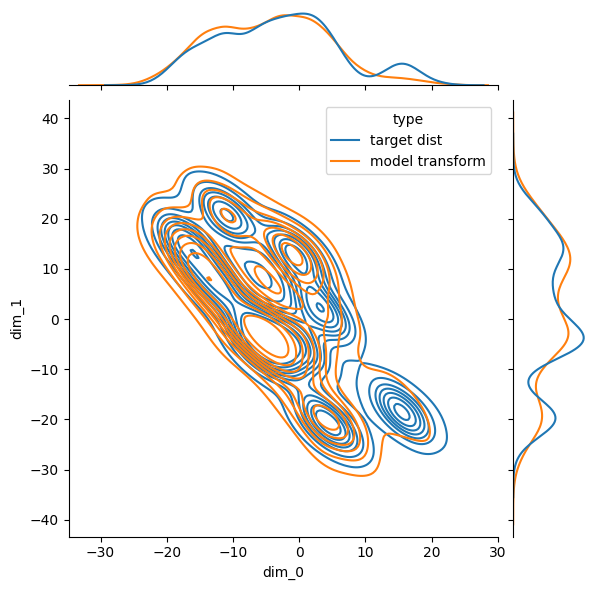

trail: 0 m step: 6 kl_test: 2.5597400665283203


  2%|▏         | 100/6000 [00:32<35:24,  2.78it/s]

trail: 0 m step: 7 Loss: 2.2973766326904297  L_n: 2.057413101196289  kld: 0.023996353149414062 KLD1: 2.025939702987671 KLD2: 1.1667721271514893


  3%|▎         | 200/6000 [01:04<34:25,  2.81it/s]

trail: 0 m step: 7 Loss: 2.294452667236328  L_n: 2.0481948852539062  kld: 0.024625778198242188 KLD1: 2.0333328247070312 KLD2: 1.1665095090866089


  5%|▌         | 300/6000 [01:37<34:02,  2.79it/s]

trail: 0 m step: 7 Loss: 2.278482437133789  L_n: 2.023660659790039  kld: 0.025482177734375 KLD1: 2.01778507232666 KLD2: 1.1381231546401978


  7%|▋         | 400/6000 [02:09<33:27,  2.79it/s]

trail: 0 m step: 7 Loss: 2.197519302368164  L_n: 1.9991931915283203  kld: 0.019832611083984375 KLD1: 2.09298038482666 KLD2: 1.12345552444458


  8%|▊         | 500/6000 [02:41<32:47,  2.80it/s]

trail: 0 m step: 7 Loss: 2.309070587158203  L_n: 2.0157012939453125  kld: 0.029336929321289062 KLD1: 1.9804850816726685 KLD2: 1.129163384437561


 10%|█         | 600/6000 [03:14<32:16,  2.79it/s]

trail: 0 m step: 7 Loss: 2.3040199279785156  L_n: 2.0039749145507812  kld: 0.030004501342773438 KLD1: 1.9559483528137207 KLD2: 1.1483111381530762


 12%|█▏        | 700/6000 [03:46<31:37,  2.79it/s]

trail: 0 m step: 7 Loss: 2.299161911010742  L_n: 2.0145092010498047  kld: 0.02846527099609375 KLD1: 1.9935663938522339 KLD2: 1.128643274307251


 13%|█▎        | 800/6000 [04:19<30:56,  2.80it/s]

trail: 0 m step: 7 Loss: 2.275392532348633  L_n: 1.9892902374267578  kld: 0.0286102294921875 KLD1: 2.003706693649292 KLD2: 1.1327462196350098


 15%|█▌        | 900/6000 [04:51<30:27,  2.79it/s]

trail: 0 m step: 7 Loss: 2.275829315185547  L_n: 1.9796943664550781  kld: 0.029613494873046875 KLD1: 1.9500644207000732 KLD2: 1.1395108699798584


 17%|█▋        | 1000/6000 [05:23<29:47,  2.80it/s]

trail: 0 m step: 7 Loss: 2.2086048126220703  L_n: 1.961221694946289  kld: 0.024738311767578125 KLD1: 2.0047738552093506 KLD2: 1.1243364810943604


 18%|█▊        | 1100/6000 [05:56<29:14,  2.79it/s]

trail: 0 m step: 7 Loss: 2.2134838104248047  L_n: 1.9305858612060547  kld: 0.028289794921875 KLD1: 1.9662706851959229 KLD2: 1.1283515691757202


 20%|██        | 1200/6000 [06:28<28:39,  2.79it/s]

trail: 0 m step: 7 Loss: 2.2306442260742188  L_n: 1.9750022888183594  kld: 0.025564193725585938 KLD1: 1.9728609323501587 KLD2: 1.1497901678085327


 22%|██▏       | 1300/6000 [07:01<27:59,  2.80it/s]

trail: 0 m step: 7 Loss: 2.2485828399658203  L_n: 1.9765567779541016  kld: 0.027202606201171875 KLD1: 2.0145504474639893 KLD2: 1.1542425155639648


 23%|██▎       | 1400/6000 [07:33<27:23,  2.80it/s]

trail: 0 m step: 7 Loss: 2.2634239196777344  L_n: 1.9711418151855469  kld: 0.02922821044921875 KLD1: 1.9499108791351318 KLD2: 1.1150574684143066


 25%|██▌       | 1500/6000 [08:05<26:45,  2.80it/s]

trail: 0 m step: 7 Loss: 2.243989944458008  L_n: 1.968912124633789  kld: 0.027507781982421875 KLD1: 1.9545536041259766 KLD2: 1.1000761985778809


 27%|██▋       | 1600/6000 [08:38<26:15,  2.79it/s]

trail: 0 m step: 7 Loss: 2.2521896362304688  L_n: 1.9687957763671875  kld: 0.028339385986328125 KLD1: 1.9740413427352905 KLD2: 1.1131683588027954


 28%|██▊       | 1700/6000 [09:10<25:37,  2.80it/s]

trail: 0 m step: 7 Loss: 2.250284194946289  L_n: 1.989969253540039  kld: 0.026031494140625 KLD1: 1.976988673210144 KLD2: 1.140832543373108


 30%|███       | 1800/6000 [09:43<24:58,  2.80it/s]

trail: 0 m step: 7 Loss: 2.2432823181152344  L_n: 1.9384307861328125  kld: 0.030485153198242188 KLD1: 1.9324620962142944 KLD2: 1.1189665794372559


 32%|███▏      | 1900/6000 [10:15<24:23,  2.80it/s]

trail: 0 m step: 7 Loss: 2.270620346069336  L_n: 1.9846134185791016  kld: 0.028600692749023438 KLD1: 1.9989776611328125 KLD2: 1.1410086154937744


 33%|███▎      | 2000/6000 [10:47<23:48,  2.80it/s]

trail: 0 m step: 7 Loss: 2.197439193725586  L_n: 1.9450016021728516  kld: 0.025243759155273438 KLD1: 1.98241126537323 KLD2: 1.1196268796920776


 35%|███▌      | 2100/6000 [11:20<23:14,  2.80it/s]

trail: 0 m step: 7 Loss: 2.231710433959961  L_n: 1.9256763458251953  kld: 0.030603408813476562 KLD1: 1.9591857194900513 KLD2: 1.137341022491455


 37%|███▋      | 2200/6000 [11:52<22:40,  2.79it/s]

trail: 0 m step: 7 Loss: 2.2136383056640625  L_n: 1.948974609375  kld: 0.02646636962890625 KLD1: 1.9731327295303345 KLD2: 1.12812340259552


 38%|███▊      | 2300/6000 [12:24<22:03,  2.80it/s]

trail: 0 m step: 7 Loss: 2.2223548889160156  L_n: 1.9243316650390625  kld: 0.029802322387695312 KLD1: 1.9619218111038208 KLD2: 1.1108360290527344


 40%|████      | 2400/6000 [12:57<21:29,  2.79it/s]

trail: 0 m step: 7 Loss: 2.2021312713623047  L_n: 1.9329853057861328  kld: 0.026914596557617188 KLD1: 1.964277744293213 KLD2: 1.1269793510437012


 42%|████▏     | 2500/6000 [13:29<20:52,  2.80it/s]

trail: 0 m step: 7 Loss: 2.183673858642578  L_n: 1.9151573181152344  kld: 0.026851654052734375 KLD1: 1.9734214544296265 KLD2: 1.1300214529037476


 43%|████▎     | 2600/6000 [14:01<20:16,  2.79it/s]

trail: 0 m step: 7 Loss: 2.275297164916992  L_n: 1.9568462371826172  kld: 0.0318450927734375 KLD1: 1.9212778806686401 KLD2: 1.1110022068023682


 45%|████▌     | 2700/6000 [14:34<19:38,  2.80it/s]

trail: 0 m step: 7 Loss: 2.2342052459716797  L_n: 1.967061996459961  kld: 0.026714324951171875 KLD1: 1.9432967901229858 KLD2: 1.1251940727233887


 47%|████▋     | 2800/6000 [15:06<19:04,  2.80it/s]

trail: 0 m step: 7 Loss: 2.2861366271972656  L_n: 1.9743423461914062  kld: 0.031179428100585938 KLD1: 1.8986554145812988 KLD2: 1.133130669593811


 48%|████▊     | 2900/6000 [15:39<18:29,  2.79it/s]

trail: 0 m step: 7 Loss: 2.2339344024658203  L_n: 1.948995590209961  kld: 0.028493881225585938 KLD1: 1.9056274890899658 KLD2: 1.1282193660736084


 50%|█████     | 3000/6000 [16:11<17:55,  2.79it/s]

trail: 0 m step: 7 Loss: 2.2394065856933594  L_n: 1.9669036865234375  kld: 0.027250289916992188 KLD1: 1.9637229442596436 KLD2: 1.107561469078064


 52%|█████▏    | 3100/6000 [16:43<17:15,  2.80it/s]

trail: 0 m step: 7 Loss: 2.2063865661621094  L_n: 1.9623985290527344  kld: 0.0243988037109375 KLD1: 1.98936927318573 KLD2: 1.1021356582641602


 53%|█████▎    | 3200/6000 [17:16<16:39,  2.80it/s]

trail: 0 m step: 7 Loss: 2.2756690979003906  L_n: 1.970703125  kld: 0.030496597290039062 KLD1: 1.9258038997650146 KLD2: 1.094468116760254


 55%|█████▌    | 3300/6000 [17:48<16:06,  2.79it/s]

trail: 0 m step: 7 Loss: 2.249086380004883  L_n: 1.9812946319580078  kld: 0.0267791748046875 KLD1: 1.9565284252166748 KLD2: 1.1050264835357666


 57%|█████▋    | 3400/6000 [18:21<15:28,  2.80it/s]

trail: 0 m step: 7 Loss: 2.1866817474365234  L_n: 1.8951435089111328  kld: 0.029153823852539062 KLD1: 1.914054274559021 KLD2: 1.1235871315002441


 58%|█████▊    | 3500/6000 [18:53<14:50,  2.81it/s]

trail: 0 m step: 7 Loss: 2.234621047973633  L_n: 1.9521808624267578  kld: 0.0282440185546875 KLD1: 1.912695288658142 KLD2: 1.1267598867416382


 60%|██████    | 3600/6000 [19:25<14:17,  2.80it/s]

trail: 0 m step: 7 Loss: 2.2131175994873047  L_n: 1.916391372680664  kld: 0.029672622680664062 KLD1: 1.9579256772994995 KLD2: 1.1423460245132446


 62%|██████▏   | 3700/6000 [19:58<13:37,  2.81it/s]

trail: 0 m step: 7 Loss: 2.2205066680908203  L_n: 1.9272708892822266  kld: 0.029323577880859375 KLD1: 1.9037448167800903 KLD2: 1.1133391857147217


 63%|██████▎   | 3800/6000 [20:30<13:06,  2.80it/s]

trail: 0 m step: 7 Loss: 2.253446578979492  L_n: 2.014017105102539  kld: 0.023942947387695312 KLD1: 1.9397085905075073 KLD2: 1.1166929006576538


 65%|██████▌   | 3900/6000 [21:02<12:31,  2.79it/s]

trail: 0 m step: 7 Loss: 2.190692901611328  L_n: 1.8739967346191406  kld: 0.03166961669921875 KLD1: 1.9006330966949463 KLD2: 1.0914123058319092


 67%|██████▋   | 4000/6000 [21:35<11:54,  2.80it/s]

trail: 0 m step: 7 Loss: 2.2229385375976562  L_n: 1.8915367126464844  kld: 0.03314018249511719 KLD1: 1.9000837802886963 KLD2: 1.1120914220809937


 68%|██████▊   | 4100/6000 [22:07<11:19,  2.79it/s]

trail: 0 m step: 7 Loss: 2.228994369506836  L_n: 1.903390884399414  kld: 0.03256034851074219 KLD1: 1.8978254795074463 KLD2: 1.1112685203552246


 70%|███████   | 4200/6000 [22:40<10:40,  2.81it/s]

trail: 0 m step: 7 Loss: 2.135082244873047  L_n: 1.8679771423339844  kld: 0.02671051025390625 KLD1: 1.9529143571853638 KLD2: 1.122415542602539


 72%|███████▏  | 4300/6000 [23:12<10:07,  2.80it/s]

trail: 0 m step: 7 Loss: 2.2065563201904297  L_n: 1.9508190155029297  kld: 0.02557373046875 KLD1: 1.9474296569824219 KLD2: 1.147965908050537


 73%|███████▎  | 4400/6000 [23:44<09:31,  2.80it/s]

trail: 0 m step: 7 Loss: 2.214132308959961  L_n: 1.924825668334961  kld: 0.0289306640625 KLD1: 1.919805645942688 KLD2: 1.1226214170455933


 75%|███████▌  | 4500/6000 [24:17<08:57,  2.79it/s]

trail: 0 m step: 7 Loss: 2.2274646759033203  L_n: 1.9554004669189453  kld: 0.0272064208984375 KLD1: 1.9595253467559814 KLD2: 1.1136335134506226


 77%|███████▋  | 4600/6000 [24:49<08:22,  2.79it/s]

trail: 0 m step: 7 Loss: 2.211038589477539  L_n: 1.9352741241455078  kld: 0.027576446533203125 KLD1: 1.9220234155654907 KLD2: 1.134077787399292


 78%|███████▊  | 4700/6000 [25:21<07:44,  2.80it/s]

trail: 0 m step: 7 Loss: 2.1519222259521484  L_n: 1.9265880584716797  kld: 0.022533416748046875 KLD1: 1.9886986017227173 KLD2: 1.1224478483200073


 80%|████████  | 4800/6000 [25:54<07:08,  2.80it/s]

trail: 0 m step: 7 Loss: 2.191446304321289  L_n: 1.9390850067138672  kld: 0.025236129760742188 KLD1: 1.983344316482544 KLD2: 1.116904854774475


 82%|████████▏ | 4900/6000 [26:26<06:32,  2.80it/s]

trail: 0 m step: 7 Loss: 2.2167205810546875  L_n: 1.9472122192382812  kld: 0.026950836181640625 KLD1: 1.912493348121643 KLD2: 1.115288496017456


 83%|████████▎ | 5000/6000 [26:59<05:58,  2.79it/s]

trail: 0 m step: 7 Loss: 2.2301502227783203  L_n: 1.9568843841552734  kld: 0.027326583862304688 KLD1: 1.9318456649780273 KLD2: 1.125160574913025


 85%|████████▌ | 5100/6000 [27:31<05:21,  2.80it/s]

trail: 0 m step: 7 Loss: 2.119365692138672  L_n: 1.8647346496582031  kld: 0.025463104248046875 KLD1: 1.9206331968307495 KLD2: 1.1301149129867554


 87%|████████▋ | 5200/6000 [28:03<04:46,  2.79it/s]

trail: 0 m step: 7 Loss: 2.2671775817871094  L_n: 1.9776611328125  kld: 0.028951644897460938 KLD1: 1.9121136665344238 KLD2: 1.1120587587356567


 88%|████████▊ | 5300/6000 [28:36<04:10,  2.80it/s]

trail: 0 m step: 7 Loss: 2.1948509216308594  L_n: 1.9344406127929688  kld: 0.026041030883789062 KLD1: 1.974013090133667 KLD2: 1.1060035228729248


 90%|█████████ | 5400/6000 [29:08<03:34,  2.80it/s]

trail: 0 m step: 7 Loss: 2.1972427368164062  L_n: 1.9472846984863281  kld: 0.024995803833007812 KLD1: 1.9414876699447632 KLD2: 1.1099939346313477


 92%|█████████▏| 5500/6000 [29:41<02:58,  2.80it/s]

trail: 0 m step: 7 Loss: 2.240612030029297  L_n: 1.9387741088867188  kld: 0.030183792114257812 KLD1: 1.9003808498382568 KLD2: 1.109383225440979


 93%|█████████▎| 5600/6000 [30:13<02:23,  2.79it/s]

trail: 0 m step: 7 Loss: 2.206026077270508  L_n: 1.9138011932373047  kld: 0.029222488403320312 KLD1: 1.9369295835494995 KLD2: 1.114569902420044


 95%|█████████▌| 5700/6000 [30:45<01:47,  2.80it/s]

trail: 0 m step: 7 Loss: 2.197957992553711  L_n: 1.9400653839111328  kld: 0.025789260864257812 KLD1: 1.9470829963684082 KLD2: 1.1269770860671997


 97%|█████████▋| 5800/6000 [31:18<01:11,  2.80it/s]

trail: 0 m step: 7 Loss: 2.2043190002441406  L_n: 1.9594917297363281  kld: 0.02448272705078125 KLD1: 1.9866222143173218 KLD2: 1.1074855327606201


 98%|█████████▊| 5900/6000 [31:50<00:35,  2.79it/s]

trail: 0 m step: 7 Loss: 2.2227134704589844  L_n: 1.9409027099609375  kld: 0.028181076049804688 KLD1: 1.9247421026229858 KLD2: 1.124072551727295


100%|██████████| 6000/6000 [32:23<00:00,  3.09it/s]

trail: 0 m step: 7 Loss: 2.172903060913086  L_n: 1.8953266143798828  kld: 0.027757644653320312 KLD1: 1.9216089248657227 KLD2: 1.1205775737762451



<ipython-input-20-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


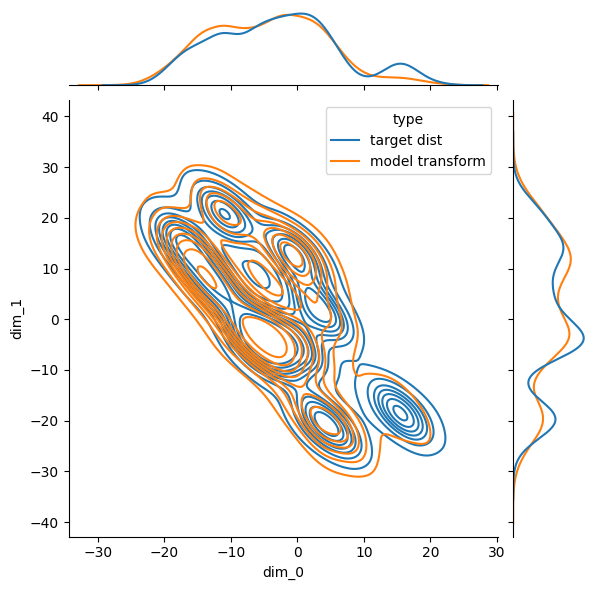

trail: 0 m step: 7 kl_test: 1.9261608123779297


  2%|▏         | 100/6000 [00:32<35:27,  2.77it/s]

trail: 0 m step: 8 Loss: 1.7918815612792969  L_n: 1.6048469543457031  kld: 0.018703460693359375 KLD1: 1.5581609010696411 KLD2: 0.9483317136764526


  3%|▎         | 200/6000 [01:04<34:25,  2.81it/s]

trail: 0 m step: 8 Loss: 1.7997074127197266  L_n: 1.6030216217041016  kld: 0.0196685791015625 KLD1: 1.5797144174575806 KLD2: 0.9451487064361572


  5%|▌         | 300/6000 [01:37<34:02,  2.79it/s]

trail: 0 m step: 8 Loss: 1.733367919921875  L_n: 1.5231971740722656  kld: 0.021017074584960938 KLD1: 1.5487905740737915 KLD2: 0.9151735901832581


  7%|▋         | 400/6000 [02:09<33:27,  2.79it/s]

trail: 0 m step: 8 Loss: 1.6989898681640625  L_n: 1.5593147277832031  kld: 0.013967514038085938 KLD1: 1.6369673013687134 KLD2: 0.9129974246025085


  8%|▊         | 500/6000 [02:41<32:50,  2.79it/s]

trail: 0 m step: 8 Loss: 1.7822017669677734  L_n: 1.572031021118164  kld: 0.021017074584960938 KLD1: 1.5166847705841064 KLD2: 0.9261142611503601


 10%|█         | 600/6000 [03:14<32:13,  2.79it/s]

trail: 0 m step: 8 Loss: 1.7672138214111328  L_n: 1.5477542877197266  kld: 0.021945953369140625 KLD1: 1.5273451805114746 KLD2: 0.9362574219703674


 12%|█▏        | 700/6000 [03:46<31:37,  2.79it/s]

trail: 0 m step: 8 Loss: 1.7739677429199219  L_n: 1.5681838989257812  kld: 0.020578384399414062 KLD1: 1.543779730796814 KLD2: 0.9165982007980347


 13%|█▎        | 800/6000 [04:19<31:00,  2.80it/s]

trail: 0 m step: 8 Loss: 1.7621479034423828  L_n: 1.5578136444091797  kld: 0.020433425903320312 KLD1: 1.5874274969100952 KLD2: 0.9243441224098206


 15%|█▌        | 900/6000 [04:51<30:22,  2.80it/s]

trail: 0 m step: 8 Loss: 1.7576656341552734  L_n: 1.5455875396728516  kld: 0.021207809448242188 KLD1: 1.5359257459640503 KLD2: 0.9338666796684265


 17%|█▋        | 1000/6000 [05:24<29:45,  2.80it/s]

trail: 0 m step: 8 Loss: 1.7117843627929688  L_n: 1.5208969116210938  kld: 0.0190887451171875 KLD1: 1.5529468059539795 KLD2: 0.9127498865127563


 18%|█▊        | 1100/6000 [05:56<29:14,  2.79it/s]

trail: 0 m step: 8 Loss: 1.7143993377685547  L_n: 1.5065364837646484  kld: 0.020786285400390625 KLD1: 1.5139350891113281 KLD2: 0.9151234030723572


 20%|██        | 1200/6000 [06:28<28:38,  2.79it/s]

trail: 0 m step: 8 Loss: 1.7080402374267578  L_n: 1.5198230743408203  kld: 0.01882171630859375 KLD1: 1.5235872268676758 KLD2: 0.9413981437683105


 22%|██▏       | 1300/6000 [07:01<28:07,  2.79it/s]

trail: 0 m step: 8 Loss: 1.7583179473876953  L_n: 1.560678482055664  kld: 0.019763946533203125 KLD1: 1.562965750694275 KLD2: 0.9458200931549072


 23%|██▎       | 1400/6000 [07:33<27:21,  2.80it/s]

trail: 0 m step: 8 Loss: 1.7742767333984375  L_n: 1.545318603515625  kld: 0.02289581298828125 KLD1: 1.5231947898864746 KLD2: 0.8982663750648499


 25%|██▌       | 1500/6000 [08:05<26:52,  2.79it/s]

trail: 0 m step: 8 Loss: 1.7154350280761719  L_n: 1.5072860717773438  kld: 0.020814895629882812 KLD1: 1.495174527168274 KLD2: 0.8877425789833069


 27%|██▋       | 1600/6000 [08:38<26:16,  2.79it/s]

trail: 0 m step: 8 Loss: 1.7284107208251953  L_n: 1.5253353118896484  kld: 0.020307540893554688 KLD1: 1.5335731506347656 KLD2: 0.9057741761207581


 28%|██▊       | 1700/6000 [09:10<25:44,  2.78it/s]

trail: 0 m step: 8 Loss: 1.7734050750732422  L_n: 1.576833724975586  kld: 0.019657135009765625 KLD1: 1.5421339273452759 KLD2: 0.9320768117904663


 30%|███       | 1800/6000 [09:43<25:05,  2.79it/s]

trail: 0 m step: 8 Loss: 1.7345867156982422  L_n: 1.5093097686767578  kld: 0.022527694702148438 KLD1: 1.473728895187378 KLD2: 0.9122524261474609


 32%|███▏      | 1900/6000 [10:15<24:27,  2.79it/s]

trail: 0 m step: 8 Loss: 1.7700176239013672  L_n: 1.5450458526611328  kld: 0.022497177124023438 KLD1: 1.5182785987854004 KLD2: 0.9272880554199219


 33%|███▎      | 2000/6000 [10:47<23:54,  2.79it/s]

trail: 0 m step: 8 Loss: 1.7068519592285156  L_n: 1.5288581848144531  kld: 0.01779937744140625 KLD1: 1.537623405456543 KLD2: 0.9186952114105225


 35%|███▌      | 2100/6000 [11:20<23:10,  2.81it/s]

trail: 0 m step: 8 Loss: 1.7177810668945312  L_n: 1.5126075744628906  kld: 0.020517349243164062 KLD1: 1.5190351009368896 KLD2: 0.9327552318572998


 37%|███▋      | 2200/6000 [11:52<22:32,  2.81it/s]

trail: 0 m step: 8 Loss: 1.7023143768310547  L_n: 1.5096721649169922  kld: 0.01926422119140625 KLD1: 1.532045841217041 KLD2: 0.9189242124557495


 38%|███▊      | 2300/6000 [12:24<22:06,  2.79it/s]

trail: 0 m step: 8 Loss: 1.6915779113769531  L_n: 1.4947395324707031  kld: 0.019683837890625 KLD1: 1.5251201391220093 KLD2: 0.9029919505119324


 40%|████      | 2400/6000 [12:57<21:26,  2.80it/s]

trail: 0 m step: 8 Loss: 1.6707592010498047  L_n: 1.4771251678466797  kld: 0.0193634033203125 KLD1: 1.5528384447097778 KLD2: 0.9141317009925842


 42%|████▏     | 2500/6000 [13:29<20:52,  2.80it/s]

trail: 0 m step: 8 Loss: 1.6574440002441406  L_n: 1.4835700988769531  kld: 0.01738739013671875 KLD1: 1.5093597173690796 KLD2: 0.9130746722221375


 43%|████▎     | 2600/6000 [14:02<20:15,  2.80it/s]

trail: 0 m step: 8 Loss: 1.727987289428711  L_n: 1.513296127319336  kld: 0.0214691162109375 KLD1: 1.4901505708694458 KLD2: 0.9002326130867004


 45%|████▌     | 2700/6000 [14:34<19:41,  2.79it/s]

trail: 0 m step: 8 Loss: 1.730621337890625  L_n: 1.5321807861328125  kld: 0.01984405517578125 KLD1: 1.5312601327896118 KLD2: 0.9125941395759583


 47%|████▋     | 2800/6000 [15:06<19:06,  2.79it/s]

trail: 0 m step: 8 Loss: 1.7725963592529297  L_n: 1.5394611358642578  kld: 0.023313522338867188 KLD1: 1.4854607582092285 KLD2: 0.9240560531616211


 48%|████▊     | 2900/6000 [15:39<18:30,  2.79it/s]

trail: 0 m step: 8 Loss: 1.765024185180664  L_n: 1.5597553253173828  kld: 0.020526885986328125 KLD1: 1.5030533075332642 KLD2: 0.9220113754272461


 50%|█████     | 3000/6000 [16:11<17:54,  2.79it/s]

trail: 0 m step: 8 Loss: 1.729269027709961  L_n: 1.5360546112060547  kld: 0.019321441650390625 KLD1: 1.5281106233596802 KLD2: 0.9037933349609375


 52%|█████▏    | 3100/6000 [16:44<17:16,  2.80it/s]

trail: 0 m step: 8 Loss: 1.7211189270019531  L_n: 1.5482368469238281  kld: 0.0172882080078125 KLD1: 1.5386544466018677 KLD2: 0.8910896182060242


 53%|█████▎    | 3200/6000 [17:16<16:40,  2.80it/s]

trail: 0 m step: 8 Loss: 1.759023666381836  L_n: 1.526803970336914  kld: 0.023221969604492188 KLD1: 1.484578251838684 KLD2: 0.8834554553031921


 55%|█████▌    | 3300/6000 [17:48<16:06,  2.79it/s]

trail: 0 m step: 8 Loss: 1.7412166595458984  L_n: 1.5524654388427734  kld: 0.0188751220703125 KLD1: 1.5214060544967651 KLD2: 0.8977221250534058


 57%|█████▋    | 3400/6000 [18:21<15:31,  2.79it/s]

trail: 0 m step: 8 Loss: 1.7092647552490234  L_n: 1.486562728881836  kld: 0.02227020263671875 KLD1: 1.466382622718811 KLD2: 0.912810742855072


 58%|█████▊    | 3500/6000 [18:53<14:56,  2.79it/s]

trail: 0 m step: 8 Loss: 1.7315235137939453  L_n: 1.5179386138916016  kld: 0.021358489990234375 KLD1: 1.4862858057022095 KLD2: 0.9196337461471558


 60%|██████    | 3600/6000 [19:26<14:19,  2.79it/s]

trail: 0 m step: 8 Loss: 1.7186164855957031  L_n: 1.4950752258300781  kld: 0.0223541259765625 KLD1: 1.4924649000167847 KLD2: 0.9396517276763916


 62%|██████▏   | 3700/6000 [19:58<13:44,  2.79it/s]

trail: 0 m step: 8 Loss: 1.7100563049316406  L_n: 1.4982452392578125  kld: 0.021181106567382812 KLD1: 1.509209394454956 KLD2: 0.9130818843841553


 63%|██████▎   | 3800/6000 [20:30<13:04,  2.80it/s]

trail: 0 m step: 8 Loss: 1.7571392059326172  L_n: 1.5946712493896484  kld: 0.016246795654296875 KLD1: 1.5148327350616455 KLD2: 0.9059001803398132


 65%|██████▌   | 3900/6000 [21:03<12:31,  2.79it/s]

trail: 0 m step: 8 Loss: 1.681182861328125  L_n: 1.4449577331542969  kld: 0.023622512817382812 KLD1: 1.4764912128448486 KLD2: 0.8852950930595398


 67%|██████▋   | 4000/6000 [21:35<11:57,  2.79it/s]

trail: 0 m step: 8 Loss: 1.7203292846679688  L_n: 1.474853515625  kld: 0.024547576904296875 KLD1: 1.4503624439239502 KLD2: 0.8989022374153137


 68%|██████▊   | 4100/6000 [22:08<11:21,  2.79it/s]

trail: 0 m step: 8 Loss: 1.7238636016845703  L_n: 1.487009048461914  kld: 0.023685455322265625 KLD1: 1.4734830856323242 KLD2: 0.8987734913825989


 70%|███████   | 4200/6000 [22:40<10:44,  2.79it/s]

trail: 0 m step: 8 Loss: 1.6368522644042969  L_n: 1.4401092529296875  kld: 0.019674301147460938 KLD1: 1.5441545248031616 KLD2: 0.9088007807731628


 72%|███████▏  | 4300/6000 [23:12<10:09,  2.79it/s]

trail: 0 m step: 8 Loss: 1.7141265869140625  L_n: 1.5153999328613281  kld: 0.019872665405273438 KLD1: 1.4913687705993652 KLD2: 0.930720865726471


 73%|███████▎  | 4400/6000 [23:45<09:32,  2.79it/s]

trail: 0 m step: 8 Loss: 1.6928272247314453  L_n: 1.4946727752685547  kld: 0.019815444946289062 KLD1: 1.5078431367874146 KLD2: 0.908973217010498


 75%|███████▌  | 4500/6000 [24:17<08:56,  2.79it/s]

trail: 0 m step: 8 Loss: 1.7119941711425781  L_n: 1.50994873046875  kld: 0.020204544067382812 KLD1: 1.5080854892730713 KLD2: 0.8982923626899719


 77%|███████▋  | 4600/6000 [24:50<08:22,  2.79it/s]

trail: 0 m step: 8 Loss: 1.7061080932617188  L_n: 1.5142097473144531  kld: 0.019189834594726562 KLD1: 1.499660611152649 KLD2: 0.9201236367225647


 78%|███████▊  | 4700/6000 [25:22<07:45,  2.79it/s]

trail: 0 m step: 8 Loss: 1.6411819458007812  L_n: 1.4878120422363281  kld: 0.015336990356445312 KLD1: 1.5396493673324585 KLD2: 0.9097711443901062


 80%|████████  | 4800/6000 [25:55<07:10,  2.79it/s]

trail: 0 m step: 8 Loss: 1.6707096099853516  L_n: 1.4967594146728516  kld: 0.01739501953125 KLD1: 1.5523327589035034 KLD2: 0.9031869173049927


 82%|████████▏ | 4900/6000 [26:27<06:32,  2.80it/s]

trail: 0 m step: 8 Loss: 1.7110404968261719  L_n: 1.5118942260742188  kld: 0.019914627075195312 KLD1: 1.4967467784881592 KLD2: 0.9031004905700684


 83%|████████▎ | 5000/6000 [26:59<05:55,  2.81it/s]

trail: 0 m step: 8 Loss: 1.7335968017578125  L_n: 1.5275840759277344  kld: 0.020601272583007812 KLD1: 1.4989855289459229 KLD2: 0.9112271070480347


 85%|████████▌ | 5100/6000 [27:32<05:21,  2.80it/s]

trail: 0 m step: 8 Loss: 1.6342697143554688  L_n: 1.454254150390625  kld: 0.018001556396484375 KLD1: 1.5010231733322144 KLD2: 0.9182996153831482


 87%|████████▋ | 5200/6000 [28:04<04:46,  2.80it/s]

trail: 0 m step: 8 Loss: 1.7427482604980469  L_n: 1.5399398803710938  kld: 0.020280838012695312 KLD1: 1.4944710731506348 KLD2: 0.902638852596283


 88%|████████▊ | 5300/6000 [28:37<04:10,  2.79it/s]

trail: 0 m step: 8 Loss: 1.6812057495117188  L_n: 1.5009231567382812  kld: 0.01802825927734375 KLD1: 1.5258758068084717 KLD2: 0.8956591486930847


 90%|█████████ | 5400/6000 [29:09<03:34,  2.80it/s]

trail: 0 m step: 8 Loss: 1.6814937591552734  L_n: 1.5144100189208984  kld: 0.0167083740234375 KLD1: 1.5378806591033936 KLD2: 0.8996594548225403


 92%|█████████▏| 5500/6000 [29:41<02:59,  2.79it/s]

trail: 0 m step: 8 Loss: 1.7320022583007812  L_n: 1.5074119567871094  kld: 0.022459030151367188 KLD1: 1.4810216426849365 KLD2: 0.901986300945282


 93%|█████████▎| 5600/6000 [30:14<02:23,  2.79it/s]

trail: 0 m step: 8 Loss: 1.7139434814453125  L_n: 1.5021514892578125  kld: 0.02117919921875 KLD1: 1.5156081914901733 KLD2: 0.9102808237075806


 95%|█████████▌| 5700/6000 [30:46<01:47,  2.79it/s]

trail: 0 m step: 8 Loss: 1.6891136169433594  L_n: 1.5051307678222656  kld: 0.018398284912109375 KLD1: 1.5133774280548096 KLD2: 0.9220041036605835


 97%|█████████▋| 5800/6000 [31:18<01:11,  2.80it/s]

trail: 0 m step: 8 Loss: 1.6822776794433594  L_n: 1.5091476440429688  kld: 0.017313003540039062 KLD1: 1.5278996229171753 KLD2: 0.9040842652320862


 98%|█████████▊| 5900/6000 [31:51<00:35,  2.79it/s]

trail: 0 m step: 8 Loss: 1.6966609954833984  L_n: 1.5036945343017578  kld: 0.019296646118164062 KLD1: 1.5136547088623047 KLD2: 0.9157736301422119


100%|██████████| 6000/6000 [32:23<00:00,  3.09it/s]

trail: 0 m step: 8 Loss: 1.6578845977783203  L_n: 1.460378646850586  kld: 0.019750595092773438 KLD1: 1.4999632835388184 KLD2: 0.9116162061691284



<ipython-input-20-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


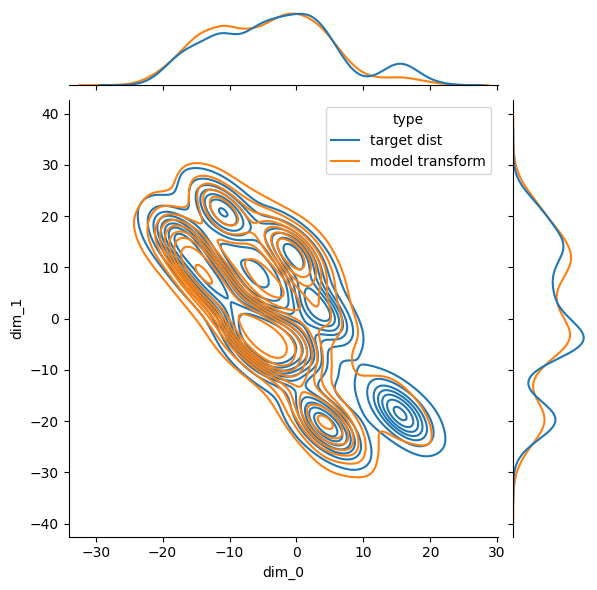

trail: 0 m step: 8 kl_test: 1.5126457214355469


  2%|▏         | 100/6000 [00:32<35:34,  2.76it/s]

trail: 0 m step: 9 Loss: 1.4012393951416016  L_n: 1.2583026885986328  kld: 0.014293670654296875 KLD1: 1.2741398811340332 KLD2: 0.7767811417579651


  3%|▎         | 200/6000 [01:05<34:36,  2.79it/s]

trail: 0 m step: 9 Loss: 1.4157390594482422  L_n: 1.2604427337646484  kld: 0.015529632568359375 KLD1: 1.2176066637039185 KLD2: 0.7735443115234375


  5%|▌         | 300/6000 [01:37<34:04,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3881187438964844  L_n: 1.21502685546875  kld: 0.017309188842773438 KLD1: 1.236154317855835 KLD2: 0.747380256652832


  7%|▋         | 400/6000 [02:09<33:27,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3514289855957031  L_n: 1.236968994140625  kld: 0.011445999145507812 KLD1: 1.2950479984283447 KLD2: 0.7461094260215759


  8%|▊         | 500/6000 [02:42<32:50,  2.79it/s]

trail: 0 m step: 9 Loss: 1.41455078125  L_n: 1.2436332702636719  kld: 0.017091751098632812 KLD1: 1.230942726135254 KLD2: 0.7635139226913452


 10%|█         | 600/6000 [03:14<32:13,  2.79it/s]

trail: 0 m step: 9 Loss: 1.387674331665039  L_n: 1.2225360870361328  kld: 0.016513824462890625 KLD1: 1.222543716430664 KLD2: 0.7731282711029053


 12%|█▏        | 700/6000 [03:47<31:41,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3827438354492188  L_n: 1.2310333251953125  kld: 0.015171051025390625 KLD1: 1.2164294719696045 KLD2: 0.7543708086013794


 13%|█▎        | 800/6000 [04:19<31:02,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3885555267333984  L_n: 1.2396869659423828  kld: 0.014886856079101562 KLD1: 1.2405461072921753 KLD2: 0.760150671005249


 15%|█▌        | 900/6000 [04:52<30:25,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3945903778076172  L_n: 1.211923599243164  kld: 0.018266677856445312 KLD1: 1.1833103895187378 KLD2: 0.7563081979751587


 17%|█▋        | 1000/6000 [05:24<29:50,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3308677673339844  L_n: 1.1909065246582031  kld: 0.013996124267578125 KLD1: 1.2291593551635742 KLD2: 0.7512149214744568


 18%|█▊        | 1100/6000 [05:56<29:18,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3908100128173828  L_n: 1.1955738067626953  kld: 0.01952362060546875 KLD1: 1.1971759796142578 KLD2: 0.7472670674324036


 20%|██        | 1200/6000 [06:29<28:42,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3597221374511719  L_n: 1.2046546936035156  kld: 0.015506744384765625 KLD1: 1.1988284587860107 KLD2: 0.7701517939567566


 22%|██▏       | 1300/6000 [07:01<28:07,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3892345428466797  L_n: 1.237600326538086  kld: 0.015163421630859375 KLD1: 1.2567362785339355 KLD2: 0.7779774069786072


 23%|██▎       | 1400/6000 [07:34<27:26,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3994674682617188  L_n: 1.2311248779296875  kld: 0.016834259033203125 KLD1: 1.2373995780944824 KLD2: 0.7429415583610535


 25%|██▌       | 1500/6000 [08:06<26:54,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3430500030517578  L_n: 1.1730670928955078  kld: 0.016998291015625 KLD1: 1.1921035051345825 KLD2: 0.7265993356704712


 27%|██▋       | 1600/6000 [08:38<26:18,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3486480712890625  L_n: 1.1945343017578125  kld: 0.015411376953125 KLD1: 1.2349514961242676 KLD2: 0.7415591478347778


 28%|██▊       | 1700/6000 [09:11<25:38,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3861236572265625  L_n: 1.241546630859375  kld: 0.01445770263671875 KLD1: 1.2577905654907227 KLD2: 0.7662928700447083


 30%|███       | 1800/6000 [09:43<25:05,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3513450622558594  L_n: 1.1876945495605469  kld: 0.01636505126953125 KLD1: 1.1814452409744263 KLD2: 0.749740719795227


 32%|███▏      | 1900/6000 [10:16<24:30,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3639812469482422  L_n: 1.200674057006836  kld: 0.016330718994140625 KLD1: 1.214867115020752 KLD2: 0.7631911635398865


 33%|███▎      | 2000/6000 [10:48<23:49,  2.80it/s]

trail: 0 m step: 9 Loss: 1.3613548278808594  L_n: 1.23846435546875  kld: 0.012289047241210938 KLD1: 1.2195602655410767 KLD2: 0.7626946568489075


 35%|███▌      | 2100/6000 [11:21<23:17,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3494071960449219  L_n: 1.1892280578613281  kld: 0.016017913818359375 KLD1: 1.2072862386703491 KLD2: 0.7667925357818604


 37%|███▋      | 2200/6000 [11:53<22:39,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3322639465332031  L_n: 1.198577880859375  kld: 0.013368606567382812 KLD1: 1.2175029516220093 KLD2: 0.7613726258277893


 38%|███▊      | 2300/6000 [12:26<22:04,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3518390655517578  L_n: 1.180521011352539  kld: 0.017131805419921875 KLD1: 1.2022767066955566 KLD2: 0.7434808611869812


 40%|████      | 2400/6000 [12:58<21:32,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3275814056396484  L_n: 1.184225082397461  kld: 0.01433563232421875 KLD1: 1.2129106521606445 KLD2: 0.7574553489685059


 42%|████▏     | 2500/6000 [13:30<20:51,  2.80it/s]

trail: 0 m step: 9 Loss: 1.294626235961914  L_n: 1.171030044555664  kld: 0.012359619140625 KLD1: 1.2119097709655762 KLD2: 0.7541059255599976


 43%|████▎     | 2600/6000 [14:03<20:17,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3307685852050781  L_n: 1.1723251342773438  kld: 0.015844345092773438 KLD1: 1.2004578113555908 KLD2: 0.746121346950531


 45%|████▌     | 2700/6000 [14:35<19:39,  2.80it/s]

trail: 0 m step: 9 Loss: 1.3580036163330078  L_n: 1.216287612915039  kld: 0.014171600341796875 KLD1: 1.2110023498535156 KLD2: 0.7540419101715088


 47%|████▋     | 2800/6000 [15:08<19:06,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3967227935791016  L_n: 1.2198734283447266  kld: 0.0176849365234375 KLD1: 1.1743100881576538 KLD2: 0.7605141401290894


 48%|████▊     | 2900/6000 [15:40<18:33,  2.78it/s]

trail: 0 m step: 9 Loss: 1.3703975677490234  L_n: 1.2120685577392578  kld: 0.015832901000976562 KLD1: 1.166633129119873 KLD2: 0.7572822570800781


 50%|█████     | 3000/6000 [16:12<17:57,  2.78it/s]

trail: 0 m step: 9 Loss: 1.3768348693847656  L_n: 1.2349853515625  kld: 0.014184951782226562 KLD1: 1.196758508682251 KLD2: 0.7475609183311462


 52%|█████▏    | 3100/6000 [16:45<17:15,  2.80it/s]

trail: 0 m step: 9 Loss: 1.3441448211669922  L_n: 1.2224369049072266  kld: 0.012170791625976562 KLD1: 1.2121237516403198 KLD2: 0.7420449256896973


 53%|█████▎    | 3200/6000 [17:17<16:41,  2.80it/s]

trail: 0 m step: 9 Loss: 1.3953018188476562  L_n: 1.2279891967773438  kld: 0.01673126220703125 KLD1: 1.1858693361282349 KLD2: 0.7360686659812927


 55%|█████▌    | 3300/6000 [17:50<16:07,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3728523254394531  L_n: 1.2352180480957031  kld: 0.013763427734375 KLD1: 1.2154273986816406 KLD2: 0.7456414103507996


 57%|█████▋    | 3400/6000 [18:22<15:31,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3307533264160156  L_n: 1.1572990417480469  kld: 0.017345428466796875 KLD1: 1.1802088022232056 KLD2: 0.7530001997947693


 58%|█████▊    | 3500/6000 [18:54<14:53,  2.80it/s]

trail: 0 m step: 9 Loss: 1.3760433197021484  L_n: 1.2176570892333984  kld: 0.015838623046875 KLD1: 1.1854948997497559 KLD2: 0.755070686340332


 60%|██████    | 3600/6000 [19:27<14:18,  2.80it/s]

trail: 0 m step: 9 Loss: 1.3462963104248047  L_n: 1.1716976165771484  kld: 0.017459869384765625 KLD1: 1.160191535949707 KLD2: 0.7723973989486694


 62%|██████▏   | 3700/6000 [19:59<13:45,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3405323028564453  L_n: 1.1774539947509766  kld: 0.016307830810546875 KLD1: 1.1787900924682617 KLD2: 0.7485851049423218


 63%|██████▎   | 3800/6000 [20:32<13:08,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3763084411621094  L_n: 1.2469711303710938  kld: 0.012933731079101562 KLD1: 1.2320468425750732 KLD2: 0.7456128597259521


 65%|██████▌   | 3900/6000 [21:04<12:31,  2.80it/s]

trail: 0 m step: 9 Loss: 1.3328380584716797  L_n: 1.1490459442138672  kld: 0.01837921142578125 KLD1: 1.1612026691436768 KLD2: 0.726544201374054


 67%|██████▋   | 4000/6000 [21:37<11:54,  2.80it/s]

trail: 0 m step: 9 Loss: 1.3908329010009766  L_n: 1.1666431427001953  kld: 0.022418975830078125 KLD1: 1.1566156148910522 KLD2: 0.7438934445381165


 68%|██████▊   | 4100/6000 [22:09<11:21,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3547534942626953  L_n: 1.1606998443603516  kld: 0.019405364990234375 KLD1: 1.1525921821594238 KLD2: 0.7357149124145508


 70%|███████   | 4200/6000 [22:42<10:45,  2.79it/s]

trail: 0 m step: 9 Loss: 1.2905864715576172  L_n: 1.1415843963623047  kld: 0.01490020751953125 KLD1: 1.176325798034668 KLD2: 0.748037576675415


 72%|███████▏  | 4300/6000 [23:14<10:08,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3495960235595703  L_n: 1.192544937133789  kld: 0.015705108642578125 KLD1: 1.1773186922073364 KLD2: 0.7637667655944824


 73%|███████▎  | 4400/6000 [23:46<09:33,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3181648254394531  L_n: 1.1690864562988281  kld: 0.0149078369140625 KLD1: 1.2138962745666504 KLD2: 0.7457833886146545


 75%|███████▌  | 4500/6000 [24:19<08:58,  2.78it/s]

trail: 0 m step: 9 Loss: 1.3371086120605469  L_n: 1.1860847473144531  kld: 0.015102386474609375 KLD1: 1.1774388551712036 KLD2: 0.7358270287513733


 77%|███████▋  | 4600/6000 [24:51<08:21,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3268566131591797  L_n: 1.1842632293701172  kld: 0.01425933837890625 KLD1: 1.190278172492981 KLD2: 0.760069727897644


 78%|███████▊  | 4700/6000 [25:24<07:45,  2.79it/s]

trail: 0 m step: 9 Loss: 1.2848072052001953  L_n: 1.1719684600830078  kld: 0.01128387451171875 KLD1: 1.2153453826904297 KLD2: 0.7498253583908081


 80%|████████  | 4800/6000 [25:56<07:09,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3417282104492188  L_n: 1.2147369384765625  kld: 0.012699127197265625 KLD1: 1.23798406124115 KLD2: 0.7457016706466675


 82%|████████▏ | 4900/6000 [26:28<06:34,  2.79it/s]

trail: 0 m step: 9 Loss: 1.344247817993164  L_n: 1.195150375366211  kld: 0.014909744262695312 KLD1: 1.1847394704818726 KLD2: 0.7415444850921631


 83%|████████▎ | 5000/6000 [27:01<05:58,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3452625274658203  L_n: 1.1957073211669922  kld: 0.014955520629882812 KLD1: 1.181365966796875 KLD2: 0.7555366158485413


 85%|████████▌ | 5100/6000 [27:33<05:22,  2.79it/s]

trail: 0 m step: 9 Loss: 1.2746734619140625  L_n: 1.1433906555175781  kld: 0.013128280639648438 KLD1: 1.2035342454910278 KLD2: 0.7567211985588074


 87%|████████▋ | 5200/6000 [28:06<04:46,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3550682067871094  L_n: 1.2038917541503906  kld: 0.015117645263671875 KLD1: 1.1800591945648193 KLD2: 0.7422048449516296


 88%|████████▊ | 5300/6000 [28:38<04:10,  2.80it/s]

trail: 0 m step: 9 Loss: 1.319650650024414  L_n: 1.1859455108642578  kld: 0.013370513916015625 KLD1: 1.2243092060089111 KLD2: 0.7367334365844727


 90%|█████████ | 5400/6000 [29:11<03:34,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3233375549316406  L_n: 1.2003898620605469  kld: 0.012294769287109375 KLD1: 1.219660758972168 KLD2: 0.7350033521652222


 92%|█████████▏| 5500/6000 [29:43<02:58,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3573131561279297  L_n: 1.188131332397461  kld: 0.016918182373046875 KLD1: 1.1926038265228271 KLD2: 0.7413355708122253


 93%|█████████▎| 5600/6000 [30:15<02:23,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3504657745361328  L_n: 1.1932048797607422  kld: 0.015726089477539062 KLD1: 1.1961126327514648 KLD2: 0.7471777200698853


 95%|█████████▌| 5700/6000 [30:48<01:47,  2.79it/s]

trail: 0 m step: 9 Loss: 1.35357666015625  L_n: 1.2190704345703125  kld: 0.01345062255859375 KLD1: 1.205902099609375 KLD2: 0.7594475150108337


 97%|█████████▋| 5800/6000 [31:20<01:11,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3337078094482422  L_n: 1.2018718719482422  kld: 0.01318359375 KLD1: 1.2232959270477295 KLD2: 0.7422502636909485


 98%|█████████▊| 5900/6000 [31:53<00:35,  2.79it/s]

trail: 0 m step: 9 Loss: 1.3484668731689453  L_n: 1.2006473541259766  kld: 0.014781951904296875 KLD1: 1.19801926612854 KLD2: 0.7542858123779297


100%|██████████| 6000/6000 [32:25<00:00,  3.08it/s]

trail: 0 m step: 9 Loss: 1.313528060913086  L_n: 1.1677494049072266  kld: 0.014577865600585938 KLD1: 1.17316472530365 KLD2: 0.7490631937980652



<ipython-input-20-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


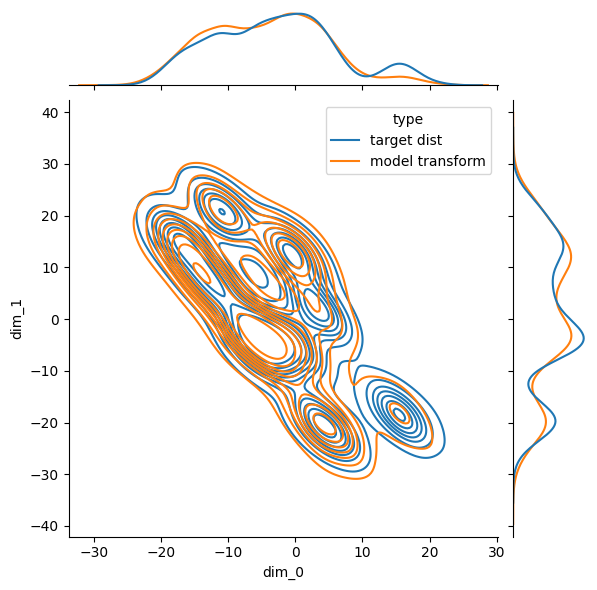

trail: 0 m step: 9 kl_test: 1.2041511535644531


In [ ]:
for mirror_itr in range(n_max_mirror_iterations):
  flows = []
  for i in range(num_layers):
      param_map = nf.nets.MLP([int(dim/2), width, width, width, dim], init_zeros=True )
      flows.append(nf.flows.AffineCouplingBlock(param_map))
      flows.append(nf.flows.Permute(dim, mode='swap'))

  # for i in range(num_layers):
  #     flows += [nf.flows.AutoregressiveRationalQuadraticSpline(dim, 2, width)]
  #     flows += [nf.flows.LULinearPermute(dim)]

  model2 = nf.NormalizingFlow(base, flows, stationary_dist).to(device)
  model2.load_state_dict(model.state_dict())
  optimizer_lr_input = optimizer_lr * (outer_lr_factor**mirror_itr)
  optimizer = torch.optim.Adam(model2.parameters(), lr=optimizer_lr_input, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

  input_eta = eta
  for it in tqdm(range(n_max_iterations), disable = not verbose):
    model2 = model2.train()
    optimizer.zero_grad()
    # torch.manual_seed(set_seed + trail_num)
    z = base.sample(num_samples)
    log_prob_rho_0 = base.log_prob(z)
    sampled_theta, log_det_model = model2.forward_and_log_det(z)
    log_prob_model = log_prob_rho_0 - log_det_model
    log_prob_prev = model.log_prob(sampled_theta)

    L_n_loss =  model2.reverse_kld(num_samples=num_samples)
    kld_loss = torch.mean(log_prob_model).to(torch.double) - torch.mean(log_prob_prev).to(torch.double)
    kld_loss = kld_loss if kld_loss.item() >= 0 else torch.tensor([0.0]).to(device)
    kld_loss = kld_loss if kld_loss.item() <= 500 else torch.tensor([500.0]).to(device)
    loss = L_n_loss   + (1/input_eta)*kld_loss

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      scheduler.step()


    if verbose:
      if it % 100 == 99:
        with torch.no_grad():
          model2.eval()
          target_samples = stationary_dist.sample((num_samples,))
          temp1 = model2.log_prob(sampled_theta) - stationary_dist.log_prob(sampled_theta)
          temp2 = stationary_dist.log_prob(target_samples) - model2.log_prob(target_samples)
        kld_1 = torch.mean(temp1)
        kld_2 = torch.mean(temp2)
        print('trail:',trail_num,'m step:',mirror_itr,'Loss:', loss.item(), ' L_n:', L_n_loss.item() , ' kld:',kld_loss.item(), 'KLD1:', kld_1.item(), 'KLD2:', kld_2.item()  )

  model.load_state_dict(model2.state_dict())
  kld1_hist = np.append(kld1_hist, kld_1.to('cpu').data.numpy())
  kld2_hist = np.append(kld2_hist, kld_2.to('cpu').data.numpy())
  with torch.no_grad():
    model.eval()
    target_samples = stationary_dist.sample((5000,))
    model_samples, _ = model.sample(5000)
    kl_test = model2.reverse_kld(num_samples=num_samples_test)
    kl_test = kl_test.cpu().detach()
  plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())
  plt.show()
  print('trail:',trail_num,'m step:',mirror_itr,'kl_test:', kl_test.item()   )


<ipython-input-20-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


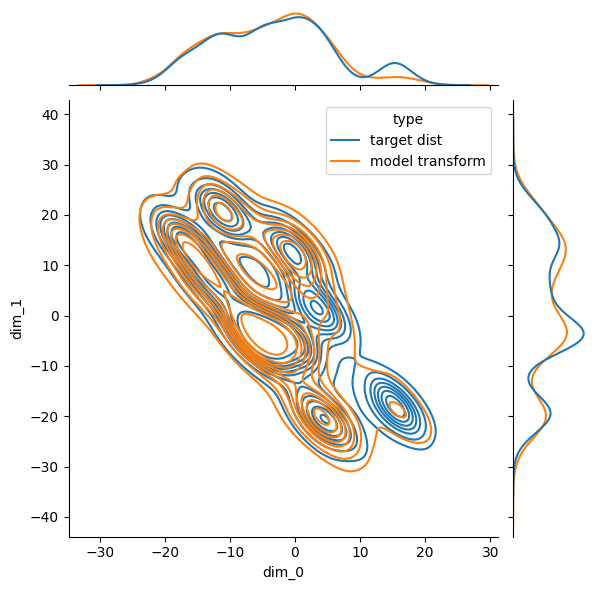

In [ ]:
target_samples = stationary_dist.sample((5000,))
model_samples, _ = model.sample(5000)
plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())

In [ ]:
for mirror_itr in range(n_max_mirror_iterations):
  flows = []
  for i in range(num_layers):
      param_map = nf.nets.MLP([int(dim/2), width, width, width, dim], init_zeros=True )
      flows.append(nf.flows.AffineCouplingBlock(param_map))
      flows.append(nf.flows.Permute(dim, mode='swap'))

  # for i in range(num_layers):
  #     flows += [nf.flows.AutoregressiveRationalQuadraticSpline(dim, 2, width)]
  #     flows += [nf.flows.LULinearPermute(dim)]

  model2 = nf.NormalizingFlow(base, flows, stationary_dist).to(device)
  model2.load_state_dict(model.state_dict())
  optimizer = torch.optim.Adam(model2.parameters(), lr=1e-5, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

  input_eta = (eta*(1.3**mirror_itr))
  for it in tqdm(range(n_max_iterations), disable = not verbose):
    model2 = model2.train()
    optimizer.zero_grad()
    # torch.manual_seed(set_seed + trail_num)
    z = base.sample(num_samples)
    log_prob_rho_0 = base.log_prob(z)
    sampled_theta, log_det_model = model2.forward_and_log_det(z)
    log_prob_model = log_prob_rho_0 - log_det_model
    log_prob_prev = model.log_prob(sampled_theta)

    L_n_loss =  model2.reverse_kld(num_samples=num_samples)
    kld_loss = torch.mean(log_prob_model).to(torch.double) - torch.mean(log_prob_prev).to(torch.double)
    kld_loss = kld_loss if kld_loss.item() >= 0 else torch.tensor([0.0]).to(device)
    kld_loss = kld_loss if kld_loss.item() <= 500 else torch.tensor([500.0]).to(device)
    loss = L_n_loss   + (1/input_eta)*kld_loss

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      scheduler.step()


    if verbose:
      if it % 100 == 99:
        with torch.no_grad():
          model2.eval()
          target_samples = stationary_dist.sample((num_samples,))
          temp1 = model2.log_prob(sampled_theta) - stationary_dist.log_prob(sampled_theta)
          temp2 = stationary_dist.log_prob(target_samples) - model2.log_prob(target_samples)
        kld_1 = torch.mean(temp1)
        kld_2 = torch.mean(temp2)
        print('trail:',trail_num,'m step:',mirror_itr,'Loss:', loss.item(), ' L_n:', L_n_loss.item() , ' kld:',kld_loss.item(), 'KLD1:', kld_1.item(), 'KLD2:', kld_2.item()  )

  model.load_state_dict(model2.state_dict())
  kld1_hist = np.append(kld1_hist, kld_1.to('cpu').data.numpy())
  kld2_hist = np.append(kld2_hist, kld_2.to('cpu').data.numpy())
  with torch.no_grad():
    model.eval()
    target_samples = stationary_dist.sample((5000,))
    model_samples, _ = model.sample(5000)
    kl_test = model2.reverse_kld(num_samples=num_samples_test)
    kl_test = kl_test.cpu().detach()
  plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())
  plt.show()
  print('trail:',trail_num,'m step:',mirror_itr,'kl_test:', kl_test.item()   )


Output hidden; open in https://colab.research.google.com to view.